In [1]:
import numpy as np
import tensorflow as tf
import lightgbm as lgb

from src.loaders.data_loader import load_train_data, load_test_data
from src.loaders.data_loader import generate_test_data, load_submission_data


np.random.seed(42)

In [2]:
from src.preprocessors.add_columns import add_sin_cos_day, add_sin_cos_hour, add_ghi

def feature_engineering(df):
#     df = add_sin_cos_day(df)
#     df = add_sin_cos_hour(df)
    df = add_ghi(df)

#     df["TARGET_ROLLING_MEAN_3"] = df["TARGET"].rolling(4).mean()
#     df["TARGET_ROLLING_MEAN_5"] = df["TARGET"].rolling(6).mean()
#     df["TARGET_ROLLING_MEAN_11"] = df["TARGET"].rolling(12).mean()
#     df["TARGET_ROLLING_MEAN_23"] = df["TARGET"].rolling(24).mean()
#     df["TARGET_ROLLING_MEAN_47"] = df["TARGET"].rolling(48).mean()
    
#     df["DHI_ROLLING_MEAN_3"] = df["DHI"].rolling(4).mean()
#     df["DHI_ROLLING_MEAN_5"] = df["DHI"].rolling(6).mean()
#     df["DHI_ROLLING_MEAN_11"] = df["DHI"].rolling(12).mean()
#     df["DHI_ROLLING_MEAN_23"] = df["DHI"].rolling(24).mean()
#     df["DHI_ROLLING_MEAN_47"] = df["DHI"].rolling(48).mean()
    
#     df["DNI_ROLLING_MEAN_3"] = df["DNI"].rolling(4).mean()
#     df["DNI_ROLLING_MEAN_5"] = df["DNI"].rolling(6).mean()
#     df["DNI_ROLLING_MEAN_11"] = df["DNI"].rolling(12).mean()
#     df["DNI_ROLLING_MEAN_23"] = df["DNI"].rolling(24).mean()
#     df["DNI_ROLLING_MEAN_47"] = df["DNI"].rolling(48).mean()
    
#     df["GHI_ROLLING_MEAN_3"] = df["GHI"].rolling(4).mean()
#     df["GHI_ROLLING_MEAN_5"] = df["GHI"].rolling(6).mean()
#     df["GHI_ROLLING_MEAN_11"] = df["GHI"].rolling(12).mean()
#     df["GHI_ROLLING_MEAN_23"] = df["GHI"].rolling(24).mean()
#     df["GHI_ROLLING_MEAN_47"] = df["GHI"].rolling(48).mean()
    
    scaled_rh = (df["RH"]) / 100
    _mean = df["T"].rolling(96).mean()
    _std = df["T"].rolling(96).std()
    df["SCALED_RH"] = scaled_rh * (df["T"] - _mean) / _std
    df["RH_CROSS_T"] = df["RH"] * df["T"]
    
    df.drop(["Day", "Hour", "Minute", "WS", "DHI", "RH", "T", "DNI", "GHI"], axis=1, inplace=True)
    
    return df

In [3]:
def learn(x_day, train, valid, test, columns):
    x_shape = x_day * (train.shape[2] - 1)
    print(len(columns), x_shape)
    print(columns)
    
    train_x, train_y_1, train_y_2 = train[:, :x_day, 1:].reshape(-1, x_shape), train[:, x_day:x_day + 1, target_index].reshape(-1), train[:, x_day + 1:, target_index].reshape(-1)
    valid_x, valid_y_1, valid_y_2 = valid[:, :x_day, 1:].reshape(-1, x_shape), valid[:, x_day:x_day + 1, target_index].reshape(-1), valid[:, x_day + 1:, target_index].reshape(-1)
    test_x, test_y_1, test_y_2 = test[:, :x_day, 1:].reshape(-1, x_shape), test[:, x_day:x_day + 1, target_index].reshape(-1), test[:, x_day + 1:, target_index].reshape(-1)
    
    
    train_1_dataset = lgb.Dataset(train_x, label=train_y_1, feature_name=columns)
    train_2_dataset = lgb.Dataset(train_x, label=train_y_2, feature_name=columns)
    valid_1_dataset = lgb.Dataset(valid_x, label=valid_y_1, feature_name=columns)
    valid_2_dataset = lgb.Dataset(valid_x, label=valid_y_2, feature_name=columns)
    test_1_dataset = lgb.Dataset(test_x, label=test_y_1, feature_name=columns)
    test_2_dataset = lgb.Dataset(test_x, label=test_y_2, feature_name=columns)
    
    submission_df = load_submission_data()

    r = 0
    bst_1_list = []
    bst_2_list = []
    for i in range(1, 10):
        q = i/10
        result = []
        param = {
        'application': 'quantile',
        'learning_rate': 0.05,
        'max_depth': 3,
        'num_leaves': 8,
        'n_jobs': 17,
        'seed': 42,
        'bagging_freq': 100,
        'feature_fraction': 0.8,
        'bagging_fraction': 0.8,
        'drop_rate': 0.2,
        'early_stopping_round': 10,
        'alpha': q,
        'boosting': 'gbdt',
        }
        
        num_round = 5000
        bst_1 = lgb.train(param, train_1_dataset, num_round, valid_sets=[valid_1_dataset])
        bst_2 = lgb.train(param, train_2_dataset, num_round, valid_sets=[valid_2_dataset])
        
        bst_1_list.append(bst_1)
        bst_2_list.append(bst_2)
        
        y_pred_1 = bst_1.predict(test_x).reshape(-1)
        y_pred_2 = bst_2.predict(test_x).reshape(-1)

        r += np.sum(np.maximum(q * (test_y_1 - y_pred_1), (q - 1) * (test_y_1 - y_pred_1)))
        r += np.sum(np.maximum(q * (test_y_2 - y_pred_2), (q - 1) * (test_y_2 - y_pred_2)))
        
        for td in generate_test_data():
            td = feature_engineering(td)
            td.drop("TARGET", inplace=True, axis=1)
            td = td.values.reshape(7, 48, -1)[(7 - x_day):, :, :].transpose(1, 0, 2).reshape(48, -1)
            result.append(bst_1.predict(td))
            result.append(bst_2.predict(td))
        
        submission_df[f"q_{q}"] = np.array(result).reshape(-1)
        
    r = r/test.shape[0]
    return r/18, submission_df, bst_1_list, bst_2_list

In [4]:
import numpy as np
np.array([1, 2, 3]) - np.array([[1], [2], [3]])

array([[ 0,  1,  2],
       [-1,  0,  1],
       [-2, -1,  0]])

In [5]:
# test.shape

In [6]:
raw_df = load_train_data()

preprocessed_df = feature_engineering(raw_df)
preprocessed_df.dropna(inplace=True)
preprocessed_df.head(10)

target_index = 0
# target_index = [i for i, s in enumerate(preprocessed_df.columns) if s == "TARGET"][0]

one_day = 48
x_day = 5
one_set = one_day * (x_day + 2)


set_df = []
target_df = []
target_df = []
for i in range(0, len(preprocessed_df) - one_set + 1, 48):
    tmp = preprocessed_df[i:i + one_set].values
    
    tmp = tmp.reshape((x_day + 2), 48, -1)
    tmp = tmp.transpose(1, 0, 2)
    x = tmp[:, :x_day, :]
    y = tmp[:, x_day:, :]
    
    for j in range(48):
        set_df.append(x[j, :, :])
        target_df.append(y[j, :, :])
           
set_df = np.array(set_df)
target_df = np.array(target_df)
set_df.shape, target_df.shape

all_df = np.concatenate((set_df, target_df), axis=1)

train = []
valid = []
test = []

length = all_df.shape[0]
boundary = [
    (slice(0, int(length * 0.6)),slice(int(length * 0.6), int(length * 0.9)), slice(int(length * 0.9), int(length * 1.0))),
    (slice(int(length * 0.1), int(length * 0.7)),slice(int(length * 0.7), int(length * 1)), slice(int(length * 0), int(length * 0.1))),    
    (slice(int(length * 0.3), int(length * 0.9)),slice(int(length * 0.9), int(length * 1)), slice(int(length * 0), int(length * 0.3))),
    (slice(int(length * 0.4), int(length * 1)),slice(int(length * 0), int(length * 0.3)), slice(int(length * 0.3), int(length * 0.4))),
]
boundary = [
    (slice(0, int(length * 0.8)),slice(int(length * 0.8), int(length * 0.9)), slice(int(length * 0.9), int(length * 1.0))),
    (slice(int(length * 0.1), int(length * 0.9)),slice(int(length * 0.9), int(length * 1)), slice(int(length * 0), int(length * 0.1))),    
    (slice(int(length * 0.2), int(length * 1)),slice(int(length * 0), int(length * 0.1)), slice(int(length * 0.1), int(length * 0.2))),
]
boundary = [
    (slice(0, int(length * 0.5)),slice(int(length * 0.5), int(length * 0.8)), slice(int(length * 0.8), int(length * 1.0))),
    (slice(int(length * 0.5), int(length * 1)),slice(int(length * 0), int(length * 0.3)), slice(int(length * 0.3), int(length * 0.5))),    
]

total_error = 0
result_list = []
result_bst_list_1 = []
result_bst_list_2 = []

for train_slice, valid_slice, test_slice in boundary:
    train, valid, test = all_df[train_slice], all_df[valid_slice], all_df[test_slice]
    
    columns = [f"{day}_{column}" for day in range(x_day) for column in preprocessed_df.columns if column != "TARGET"]
    
    error, result_df, result_bst_1, result_bst_2 = learn(x_day, train, valid, test, columns)
    total_error += error
    result_list.append(result_df)
    result_bst_list_1.append(result_bst_1)
    result_bst_list_2.append(result_bst_2)
    

10 10
['0_SCALED_RH', '0_RH_CROSS_T', '1_SCALED_RH', '1_RH_CROSS_T', '2_SCALED_RH', '2_RH_CROSS_T', '3_SCALED_RH', '3_RH_CROSS_T', '4_SCALED_RH', '4_RH_CROSS_T']
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000440 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 26088, number of used features: 10
[1]	valid_0's quantile: 1.74827
Training until validation scores don't improve for 10 rounds
[2]	valid_0's quantile: 1.74465
[3]	valid_0's quantile: 1.73732
[4]	valid_0's quantile: 1.73227
[5]	valid_0's quantile: 1.72377
[6]	valid_0's quantile: 1.71733
[7]	valid_0's quantile: 1.71519
[8]	valid_0's quantile: 1.71189
[9]	valid_0's quantile: 1.70466
[10]	valid_0's quantile: 1.69924
[11]	valid_0's quantile: 1.69496
[12]	valid_0's quantile: 1.69041
[13]	valid_0's quantile: 1.68733
[14]	valid_0's quantile: 1.68311
[15]	valid_0's quantile: 1.67818

C:\Users\bees1\anaconda3\envs\dacon\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[58]	valid_0's quantile: 1.622
[59]	valid_0's quantile: 1.62103
[60]	valid_0's quantile: 1.62066
[61]	valid_0's quantile: 1.62028
[62]	valid_0's quantile: 1.62
[63]	valid_0's quantile: 1.61985
[64]	valid_0's quantile: 1.6196
[65]	valid_0's quantile: 1.61982
[66]	valid_0's quantile: 1.61997
[67]	valid_0's quantile: 1.61968
[68]	valid_0's quantile: 1.61926
[69]	valid_0's quantile: 1.61915
[70]	valid_0's quantile: 1.61934
[71]	valid_0's quantile: 1.61908
[72]	valid_0's quantile: 1.61868
[73]	valid_0's quantile: 1.61887
[74]	valid_0's quantile: 1.61889
[75]	valid_0's quantile: 1.61867
[76]	valid_0's quantile: 1.61807
[77]	valid_0's quantile: 1.61745
[78]	valid_0's quantile: 1.61676
[79]	valid_0's quantile: 1.61597
[80]	valid_0's quantile: 1.61568
[81]	valid_0's quantile: 1.61534
[82]	valid_0's quantile: 1.6152
[83]	valid_0's quantile: 1.61538
[84]	valid_0's quantile: 1.61524
[85]	valid_0's quantile: 1.61472
[86]	valid_0's quantile: 1.61441
[87]	valid_0's quantile: 1.61392
[88]	valid_0's qu

[40]	valid_0's quantile: 2.9276
[41]	valid_0's quantile: 2.92176
[42]	valid_0's quantile: 2.91946
[43]	valid_0's quantile: 2.91918
[44]	valid_0's quantile: 2.91827
[45]	valid_0's quantile: 2.91284
[46]	valid_0's quantile: 2.90961
[47]	valid_0's quantile: 2.90841
[48]	valid_0's quantile: 2.90468
[49]	valid_0's quantile: 2.90428
[50]	valid_0's quantile: 2.9001
[51]	valid_0's quantile: 2.8979
[52]	valid_0's quantile: 2.89517
[53]	valid_0's quantile: 2.89375
[54]	valid_0's quantile: 2.89344
[55]	valid_0's quantile: 2.89322
[56]	valid_0's quantile: 2.89213
[57]	valid_0's quantile: 2.89242
[58]	valid_0's quantile: 2.89142
[59]	valid_0's quantile: 2.89105
[60]	valid_0's quantile: 2.88836
[61]	valid_0's quantile: 2.88753
[62]	valid_0's quantile: 2.8876
[63]	valid_0's quantile: 2.88763
[64]	valid_0's quantile: 2.8867
[65]	valid_0's quantile: 2.88674
[66]	valid_0's quantile: 2.88598
[67]	valid_0's quantile: 2.88573
[68]	valid_0's quantile: 2.88582
[69]	valid_0's quantile: 2.88429
[70]	valid_0's 

[136]	valid_0's quantile: 3.71216
[137]	valid_0's quantile: 3.71197
[138]	valid_0's quantile: 3.71195
[139]	valid_0's quantile: 3.71177
[140]	valid_0's quantile: 3.71131
[141]	valid_0's quantile: 3.71093
[142]	valid_0's quantile: 3.71131
[143]	valid_0's quantile: 3.71134
[144]	valid_0's quantile: 3.71122
[145]	valid_0's quantile: 3.71112
[146]	valid_0's quantile: 3.71107
[147]	valid_0's quantile: 3.71011
[148]	valid_0's quantile: 3.71011
[149]	valid_0's quantile: 3.71003
[150]	valid_0's quantile: 3.71024
[151]	valid_0's quantile: 3.71003
[152]	valid_0's quantile: 3.71022
[153]	valid_0's quantile: 3.71023
[154]	valid_0's quantile: 3.70995
[155]	valid_0's quantile: 3.71006
[156]	valid_0's quantile: 3.71043
[157]	valid_0's quantile: 3.71019
[158]	valid_0's quantile: 3.71026
[159]	valid_0's quantile: 3.70947
[160]	valid_0's quantile: 3.70934
[161]	valid_0's quantile: 3.70938
[162]	valid_0's quantile: 3.7093
[163]	valid_0's quantile: 3.70924
[164]	valid_0's quantile: 3.70904
[165]	valid_0's

[445]	valid_0's quantile: 3.67202
[446]	valid_0's quantile: 3.67077
[447]	valid_0's quantile: 3.67037
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[448]	valid_0's quantile: 3.67036
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[449]	valid_0's quantile: 3.67035
[450]	valid_0's quantile: 3.66999
[451]	valid_0's quantile: 3.66855
[452]	valid_0's quantile: 3.66789
[453]	valid_0's quantile: 3.6679
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[454]	valid_0's quantile: 3.668
[455]	valid_0's quantile: 3.66749
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[456]	valid_0's quantile: 3.66762
[457]	valid_0's quantile: 3.66793
[458]	valid_0's quantile: 3.66808
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[459]	valid_0's quantile: 3.66815
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[460]	valid_0's quantile: 3.66826
[LightGBM

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000412 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 26088, number of used features: 10
[1]	valid_0's quantile: 6.81056
Training until validation scores don't improve for 10 rounds
[2]	valid_0's quantile: 6.63032
[3]	valid_0's quantile: 6.46192
[4]	valid_0's quantile: 6.29251
[5]	valid_0's quantile: 6.14269
[6]	valid_0's quantile: 6.00621
[7]	valid_0's quantile: 5.8725
[8]	valid_0's quantile: 5.76037
[9]	valid_0's quantile: 5.65142
[10]	valid_0's quantile: 5.54997
[11]	valid_0's quantile: 5.45714
[12]	valid_0's quantile: 5.37202
[13]	valid_0's quantile: 5.28929
[14]	valid_0's quantile: 5.21764
[15]	valid_0's quantile: 5.14822
[16]	valid_0's quantile: 5.08895
[17]	valid_0's quantile: 5.03181
[18]	valid_0's quantile: 4.97792
[19]	valid_0's quantile: 4.92582
[20]	valid_0's quantile: 4.879

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000421 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 26088, number of used features: 10
[1]	valid_0's quantile: 8.42491
Training until validation scores don't improve for 10 rounds
[2]	valid_0's quantile: 8.12817
[3]	valid_0's quantile: 7.8355
[4]	valid_0's quantile: 7.56894
[5]	valid_0's quantile: 7.32057
[6]	valid_0's quantile: 7.0908
[7]	valid_0's quantile: 6.87751
[8]	valid_0's quantile: 6.68516
[9]	valid_0's quantile: 6.50232
[10]	valid_0's quantile: 6.34208
[11]	valid_0's quantile: 6.20149
[12]	valid_0's quantile: 6.07172
[13]	valid_0's quantile: 5.94991
[14]	valid_0's quantile: 5.83787
[15]	valid_0's quantile: 5.73238
[16]	valid_0's quantile: 5.63508
[17]	valid_0's quantile: 5.55218
[18]	valid_0's quantile: 5.47147
[19]	valid_0's quantile: 5.40332
[20]	valid_0's quantile: 5.3335

[76]	valid_0's quantile: 4.52766
[77]	valid_0's quantile: 4.52573
[78]	valid_0's quantile: 4.52508
[79]	valid_0's quantile: 4.52267
[80]	valid_0's quantile: 4.51991
[81]	valid_0's quantile: 4.51989
[82]	valid_0's quantile: 4.51771
[83]	valid_0's quantile: 4.51582
[84]	valid_0's quantile: 4.51434
[85]	valid_0's quantile: 4.51237
[86]	valid_0's quantile: 4.51188
[87]	valid_0's quantile: 4.50982
[88]	valid_0's quantile: 4.50853
[89]	valid_0's quantile: 4.50712
[90]	valid_0's quantile: 4.50685
[91]	valid_0's quantile: 4.50608
[92]	valid_0's quantile: 4.50565
[93]	valid_0's quantile: 4.50495
[94]	valid_0's quantile: 4.50344
[95]	valid_0's quantile: 4.50284
[96]	valid_0's quantile: 4.50255
[97]	valid_0's quantile: 4.50239
[98]	valid_0's quantile: 4.50202
[99]	valid_0's quantile: 4.5019
[100]	valid_0's quantile: 4.50134
[101]	valid_0's quantile: 4.50099
[102]	valid_0's quantile: 4.50034
[103]	valid_0's quantile: 4.50037
[104]	valid_0's quantile: 4.50014
[105]	valid_0's quantile: 4.50017
[106]

[141]	valid_0's quantile: 4.3824
[142]	valid_0's quantile: 4.38209
[143]	valid_0's quantile: 4.38126
[144]	valid_0's quantile: 4.38082
[145]	valid_0's quantile: 4.38026
[146]	valid_0's quantile: 4.38019
[147]	valid_0's quantile: 4.37991
[148]	valid_0's quantile: 4.37984
[149]	valid_0's quantile: 4.37981
[150]	valid_0's quantile: 4.37996
[151]	valid_0's quantile: 4.37951
[152]	valid_0's quantile: 4.3793
[153]	valid_0's quantile: 4.37904
[154]	valid_0's quantile: 4.37871
[155]	valid_0's quantile: 4.37941
[156]	valid_0's quantile: 4.37949
[157]	valid_0's quantile: 4.37938
[158]	valid_0's quantile: 4.37908
[159]	valid_0's quantile: 4.37924
[160]	valid_0's quantile: 4.37898
[161]	valid_0's quantile: 4.37876
[162]	valid_0's quantile: 4.37874
[163]	valid_0's quantile: 4.37873
[164]	valid_0's quantile: 4.37853
[165]	valid_0's quantile: 4.37851
[166]	valid_0's quantile: 4.3785
[167]	valid_0's quantile: 4.37821
[168]	valid_0's quantile: 4.37795
[169]	valid_0's quantile: 4.37799
[170]	valid_0's q

[327]	valid_0's quantile: 3.96935
[328]	valid_0's quantile: 3.9694
[329]	valid_0's quantile: 3.96921
[330]	valid_0's quantile: 3.96915
[331]	valid_0's quantile: 3.96915
[332]	valid_0's quantile: 3.96915
[333]	valid_0's quantile: 3.96854
[334]	valid_0's quantile: 3.9688
[335]	valid_0's quantile: 3.96904
[336]	valid_0's quantile: 3.96904
[337]	valid_0's quantile: 3.96904
[338]	valid_0's quantile: 3.96904
[339]	valid_0's quantile: 3.96904
[340]	valid_0's quantile: 3.96906
[341]	valid_0's quantile: 3.96904
[342]	valid_0's quantile: 3.96901
[343]	valid_0's quantile: 3.969
Early stopping, best iteration is:
[333]	valid_0's quantile: 3.96854
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000362 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 26088, number of used features: 10
[LightGBM] [Info] Start training from score 23.647898
[1]	valid_0

[330]	valid_0's quantile: 3.29729
[331]	valid_0's quantile: 3.29729
[332]	valid_0's quantile: 3.29724
[333]	valid_0's quantile: 3.29717
[334]	valid_0's quantile: 3.2971
[335]	valid_0's quantile: 3.29726
[336]	valid_0's quantile: 3.2973
[337]	valid_0's quantile: 3.29728
[338]	valid_0's quantile: 3.2972
[339]	valid_0's quantile: 3.2972
[340]	valid_0's quantile: 3.29706
[341]	valid_0's quantile: 3.29707
[342]	valid_0's quantile: 3.29694
[343]	valid_0's quantile: 3.29688
[344]	valid_0's quantile: 3.29676
[345]	valid_0's quantile: 3.29676
[346]	valid_0's quantile: 3.29657
[347]	valid_0's quantile: 3.29651
[348]	valid_0's quantile: 3.29652
[349]	valid_0's quantile: 3.2965
[350]	valid_0's quantile: 3.29652
[351]	valid_0's quantile: 3.29663
[352]	valid_0's quantile: 3.29665
[353]	valid_0's quantile: 3.29665
[354]	valid_0's quantile: 3.29646
[355]	valid_0's quantile: 3.29641
[356]	valid_0's quantile: 3.29559
[357]	valid_0's quantile: 3.29467
[358]	valid_0's quantile: 3.29467
[359]	valid_0's qua

[145]	valid_0's quantile: 3.32234
[146]	valid_0's quantile: 3.32135
[147]	valid_0's quantile: 3.32105
[148]	valid_0's quantile: 3.32105
[149]	valid_0's quantile: 3.32087
[150]	valid_0's quantile: 3.32066
[151]	valid_0's quantile: 3.32069
[152]	valid_0's quantile: 3.32052
[153]	valid_0's quantile: 3.32015
[154]	valid_0's quantile: 3.31978
[155]	valid_0's quantile: 3.31939
[156]	valid_0's quantile: 3.31925
[157]	valid_0's quantile: 3.31914
[158]	valid_0's quantile: 3.3189
[159]	valid_0's quantile: 3.31828
[160]	valid_0's quantile: 3.31821
[161]	valid_0's quantile: 3.31769
[162]	valid_0's quantile: 3.31766
[163]	valid_0's quantile: 3.31763
[164]	valid_0's quantile: 3.31751
[165]	valid_0's quantile: 3.31753
[166]	valid_0's quantile: 3.31747
[167]	valid_0's quantile: 3.31711
[168]	valid_0's quantile: 3.31712
[169]	valid_0's quantile: 3.31698
[170]	valid_0's quantile: 3.31621
[171]	valid_0's quantile: 3.3161
[172]	valid_0's quantile: 3.31578
[173]	valid_0's quantile: 3.31572
[174]	valid_0's 

[318]	valid_0's quantile: 2.15193
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[319]	valid_0's quantile: 2.1511
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[320]	valid_0's quantile: 2.15107
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[321]	valid_0's quantile: 2.15102
[322]	valid_0's quantile: 2.14996
[323]	valid_0's quantile: 2.14984
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[324]	valid_0's quantile: 2.14865
[325]	valid_0's quantile: 2.1485
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[326]	valid_0's quantile: 2.14851
[327]	valid_0's quantile: 2.14818
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[328]	valid_0's quantile: 2.14728
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[329]	valid_0's quantile: 2.14701
[330]	valid_0's quantile: 2.14697
[331]	valid_0's quantile: 2.14697
[

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[249]	valid_0's quantile: 2.18027
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[250]	valid_0's quantile: 2.18027
[251]	valid_0's quantile: 2.18026
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[252]	valid_0's quantile: 2.17934
[253]	valid_0's quantile: 2.1793
[254]	valid_0's quantile: 2.17931
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[255]	valid_0's quantile: 2.17842
[256]	valid_0's quantile: 2.17832
[257]	valid_0's quantile: 2.17828
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[258]	valid_0's quantile: 2.17827
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[259]	valid_0's quantile: 2.1769
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[260]	valid_0's quantile: 2.17597
[LightGBM] [Warning] No further splits with positive gain, best gain:

[558]	valid_0's quantile: 2.1236
[559]	valid_0's quantile: 2.12328
[560]	valid_0's quantile: 2.12299
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[561]	valid_0's quantile: 2.12301
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[562]	valid_0's quantile: 2.12301
[563]	valid_0's quantile: 2.12252
[564]	valid_0's quantile: 2.12253
[565]	valid_0's quantile: 2.12231
[566]	valid_0's quantile: 2.12196
[567]	valid_0's quantile: 2.12144
[568]	valid_0's quantile: 2.12097
[569]	valid_0's quantile: 2.12057
[570]	valid_0's quantile: 2.12057
[571]	valid_0's quantile: 2.12056
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[572]	valid_0's quantile: 2.1205
[573]	valid_0's quantile: 2.12016
[574]	valid_0's quantile: 2.12015
[575]	valid_0's quantile: 2.12001
[576]	valid_0's quantile: 2.11968
[577]	valid_0's quantile: 2.11925
[578]	valid_0's quantile: 2.11927
[579]	valid_0's quantile: 2.11931
[580]	valid_0's quantile: 2.1

[66]	valid_0's quantile: 1.66146
[67]	valid_0's quantile: 1.66138
[68]	valid_0's quantile: 1.661
[69]	valid_0's quantile: 1.66096
[70]	valid_0's quantile: 1.66075
[71]	valid_0's quantile: 1.66046
[72]	valid_0's quantile: 1.66015
[73]	valid_0's quantile: 1.66022
[74]	valid_0's quantile: 1.65999
[75]	valid_0's quantile: 1.65994
[76]	valid_0's quantile: 1.65971
[77]	valid_0's quantile: 1.65968
[78]	valid_0's quantile: 1.65961
[79]	valid_0's quantile: 1.65972
[80]	valid_0's quantile: 1.65956
[81]	valid_0's quantile: 1.65953
[82]	valid_0's quantile: 1.65966
[83]	valid_0's quantile: 1.65963
[84]	valid_0's quantile: 1.65985
[85]	valid_0's quantile: 1.66025
[86]	valid_0's quantile: 1.66068
[87]	valid_0's quantile: 1.66068
[88]	valid_0's quantile: 1.6608
[89]	valid_0's quantile: 1.66113
[90]	valid_0's quantile: 1.6615
[91]	valid_0's quantile: 1.6613
Early stopping, best iteration is:
[81]	valid_0's quantile: 1.65953
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of te

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000420 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 26088, number of used features: 10
[1]	valid_0's quantile: 5.36503
Training until validation scores don't improve for 10 rounds
[2]	valid_0's quantile: 5.25173
[3]	valid_0's quantile: 5.14794
[4]	valid_0's quantile: 5.04871
[5]	valid_0's quantile: 4.95876
[6]	valid_0's quantile: 4.87061
[7]	valid_0's quantile: 4.79902
[8]	valid_0's quantile: 4.72565
[9]	valid_0's quantile: 4.65608
[10]	valid_0's quantile: 4.59856
[11]	valid_0's quantile: 4.54391
[12]	valid_0's quantile: 4.49466
[13]	valid_0's quantile: 4.44571
[14]	valid_0's quantile: 4.39788
[15]	valid_0's quantile: 4.35692
[16]	valid_0's quantile: 4.33087
[17]	valid_0's quantile: 4.2961
[18]	valid_0's quantile: 4.26351
[19]	valid_0's quantile: 4.23485
[20]	valid_0's quantile: 4.209

[73]	valid_0's quantile: 3.97494
[74]	valid_0's quantile: 3.97392
[75]	valid_0's quantile: 3.97393
[76]	valid_0's quantile: 3.97367
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[77]	valid_0's quantile: 3.97367
[78]	valid_0's quantile: 3.97054
[79]	valid_0's quantile: 3.97048
[80]	valid_0's quantile: 3.97033
[81]	valid_0's quantile: 3.96943
[82]	valid_0's quantile: 3.96957
[83]	valid_0's quantile: 3.96958
[84]	valid_0's quantile: 3.96956
[85]	valid_0's quantile: 3.96969
[86]	valid_0's quantile: 3.96968
[87]	valid_0's quantile: 3.96896
[88]	valid_0's quantile: 3.96906
[89]	valid_0's quantile: 3.96919
[90]	valid_0's quantile: 3.96919
[91]	valid_0's quantile: 3.9692
[92]	valid_0's quantile: 3.9692
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[93]	valid_0's quantile: 3.96942
[94]	valid_0's quantile: 3.97063
[95]	valid_0's quantile: 3.97061
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[96]	valid_0's qua

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000428 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 26088, number of used features: 10
[1]	valid_0's quantile: 8.7777
Training until validation scores don't improve for 10 rounds
[2]	valid_0's quantile: 8.44659
[3]	valid_0's quantile: 8.13924
[4]	valid_0's quantile: 7.86325
[5]	valid_0's quantile: 7.59823
[6]	valid_0's quantile: 7.36242
[7]	valid_0's quantile: 7.15184
[8]	valid_0's quantile: 6.95055
[9]	valid_0's quantile: 6.77183
[10]	valid_0's quantile: 6.6035
[11]	valid_0's quantile: 6.45869
[12]	valid_0's quantile: 6.32105
[13]	valid_0's quantile: 6.20027
[14]	valid_0's quantile: 6.09157
[15]	valid_0's quantile: 5.98317
[16]	valid_0's quantile: 5.89182
[17]	valid_0's quantile: 5.80558
[18]	valid_0's quantile: 5.72735
[19]	valid_0's quantile: 5.65198
[20]	valid_0's quantile: 5.5851

[127]	valid_0's quantile: 4.82308
[128]	valid_0's quantile: 4.82301
[129]	valid_0's quantile: 4.82297
[130]	valid_0's quantile: 4.82302
[131]	valid_0's quantile: 4.82187
[132]	valid_0's quantile: 4.82172
[133]	valid_0's quantile: 4.82196
[134]	valid_0's quantile: 4.82176
[135]	valid_0's quantile: 4.82191
[136]	valid_0's quantile: 4.82204
[137]	valid_0's quantile: 4.82218
[138]	valid_0's quantile: 4.82205
[139]	valid_0's quantile: 4.82196
[140]	valid_0's quantile: 4.82211
[141]	valid_0's quantile: 4.82211
[142]	valid_0's quantile: 4.82199
Early stopping, best iteration is:
[132]	valid_0's quantile: 4.82172
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000378 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 26088, number of used features: 10
[LightGBM] [Info] Start training from score 8.632183
[1]	valid_0's quantile: 10.0774
Training u

[132]	valid_0's quantile: 4.70464
[133]	valid_0's quantile: 4.70444
[134]	valid_0's quantile: 4.70409
[135]	valid_0's quantile: 4.70398
[136]	valid_0's quantile: 4.70369
[137]	valid_0's quantile: 4.70343
[138]	valid_0's quantile: 4.70358
[139]	valid_0's quantile: 4.70283
[140]	valid_0's quantile: 4.70231
[141]	valid_0's quantile: 4.70232
[142]	valid_0's quantile: 4.7019
[143]	valid_0's quantile: 4.70191
[144]	valid_0's quantile: 4.70131
[145]	valid_0's quantile: 4.70114
[146]	valid_0's quantile: 4.70115
[147]	valid_0's quantile: 4.70105
[148]	valid_0's quantile: 4.70102
[149]	valid_0's quantile: 4.69801
[150]	valid_0's quantile: 4.69657
[151]	valid_0's quantile: 4.69644
[152]	valid_0's quantile: 4.69639
[153]	valid_0's quantile: 4.69631
[154]	valid_0's quantile: 4.69626
[155]	valid_0's quantile: 4.69618
[156]	valid_0's quantile: 4.69573
[157]	valid_0's quantile: 4.69571
[158]	valid_0's quantile: 4.69569
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[159]	va

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000355 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 26088, number of used features: 10
[LightGBM] [Info] Start training from score 23.554470
[1]	valid_0's quantile: 10.2632
Training until validation scores don't improve for 10 rounds
[2]	valid_0's quantile: 9.85427
[3]	valid_0's quantile: 9.46813
[4]	valid_0's quantile: 9.11204
[5]	valid_0's quantile: 8.77533
[6]	valid_0's quantile: 8.46751
[7]	valid_0's quantile: 8.18928
[8]	valid_0's quantile: 7.92574
[9]	valid_0's quantile: 7.68109
[10]	valid_0's quantile: 7.44506
[11]	valid_0's quantile: 7.23046
[12]	valid_0's quantile: 7.02865
[13]	valid_0's quantile: 6.84638
[14]	valid_0's quantile: 6.66428
[15]	valid_0's quantile: 6.50407
[16]	valid_0's quantile: 6.35713
[17]	valid_0's quantile: 6.21663
[18]	valid_0's quantile: 6.08571
[19]	val

[77]	valid_0's quantile: 4.30456
[78]	valid_0's quantile: 4.30157
[79]	valid_0's quantile: 4.29858
[80]	valid_0's quantile: 4.2958
[81]	valid_0's quantile: 4.29324
[82]	valid_0's quantile: 4.29084
[83]	valid_0's quantile: 4.28843
[84]	valid_0's quantile: 4.28615
[85]	valid_0's quantile: 4.28415
[86]	valid_0's quantile: 4.2822
[87]	valid_0's quantile: 4.2804
[88]	valid_0's quantile: 4.27862
[89]	valid_0's quantile: 4.27699
[90]	valid_0's quantile: 4.27487
[91]	valid_0's quantile: 4.27317
[92]	valid_0's quantile: 4.27171
[93]	valid_0's quantile: 4.2702
[94]	valid_0's quantile: 4.26878
[95]	valid_0's quantile: 4.26758
[96]	valid_0's quantile: 4.26664
[97]	valid_0's quantile: 4.26555
[98]	valid_0's quantile: 4.26479
[99]	valid_0's quantile: 4.26354
[100]	valid_0's quantile: 4.26269
[101]	valid_0's quantile: 4.26177
[102]	valid_0's quantile: 4.26107
[103]	valid_0's quantile: 4.26026
[104]	valid_0's quantile: 4.25967
[105]	valid_0's quantile: 4.25947
[106]	valid_0's quantile: 4.25953
[107]	v

[169]	valid_0's quantile: 3.43694
[170]	valid_0's quantile: 3.43701
[171]	valid_0's quantile: 3.43704
[172]	valid_0's quantile: 3.43723
[173]	valid_0's quantile: 3.43723
[174]	valid_0's quantile: 3.43725
[175]	valid_0's quantile: 3.43689
[176]	valid_0's quantile: 3.43658
[177]	valid_0's quantile: 3.4365
[178]	valid_0's quantile: 3.43652
[179]	valid_0's quantile: 3.43654
[180]	valid_0's quantile: 3.43653
[181]	valid_0's quantile: 3.43643
[182]	valid_0's quantile: 3.43635
[183]	valid_0's quantile: 3.4364
[184]	valid_0's quantile: 3.43642
[185]	valid_0's quantile: 3.43643
[186]	valid_0's quantile: 3.43635
[187]	valid_0's quantile: 3.43628
[188]	valid_0's quantile: 3.43689
[189]	valid_0's quantile: 3.43588
[190]	valid_0's quantile: 3.43618
[191]	valid_0's quantile: 3.43624
[192]	valid_0's quantile: 3.43626
[193]	valid_0's quantile: 3.43617
[194]	valid_0's quantile: 3.43605
[195]	valid_0's quantile: 3.43384
[196]	valid_0's quantile: 3.43379
[197]	valid_0's quantile: 3.43313
[198]	valid_0's 

[311]	valid_0's quantile: 2.14112
[312]	valid_0's quantile: 2.14114
[313]	valid_0's quantile: 2.14137
[314]	valid_0's quantile: 2.14103
[315]	valid_0's quantile: 2.1411
[316]	valid_0's quantile: 2.14114
[317]	valid_0's quantile: 2.14114
[318]	valid_0's quantile: 2.14116
[319]	valid_0's quantile: 2.14092
[320]	valid_0's quantile: 2.14098
[321]	valid_0's quantile: 2.14087
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[322]	valid_0's quantile: 2.14088
[323]	valid_0's quantile: 2.14064
[324]	valid_0's quantile: 2.14023
[325]	valid_0's quantile: 2.14022
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[326]	valid_0's quantile: 2.14029
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[327]	valid_0's quantile: 2.14023
[328]	valid_0's quantile: 2.14002
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[329]	valid_0's quantile: 2.14001
[LightGBM] [Warning] No further splits with positive ga

In [7]:
total_error/ len(boundary)

3.588311827487448

In [8]:
preprocessed_df.head(5)

,TARGET,SCALED_RH,RH_CROSS_T
95,0.0,-0.151448,-579.92
96,0.0,-0.162890,-590.40
97,0.0,-0.158719,-545.60
98,0.0,-0.169167,-552.48
99,0.0,-0.177725,-552.32


In [9]:
submission_df = load_submission_data()

for result_df in result_list:
    for i in range(1, 10):
        q = i/10
        submission_df[f"q_{q}"] += result_df[f"q_{q}"]
                      
for i in range(1, 10):
    q = i/10
    submission_df[f"q_{q}"] = submission_df[f"q_{q}"] / len(boundary)

In [10]:
submission_df[:48]

,id,q_0.1,q_0.2,q_0.3,q_0.4,q_0.5,q_0.6,q_0.7,q_0.8,q_0.9
0,0.csv_Day7_0h00m,0.000000,0.000000,0.000000,0.000000,0.000000,0.002960,0.017013,0.069893,0.182861
1,0.csv_Day7_0h30m,0.000000,0.000000,0.000000,0.000000,0.000000,0.002960,0.007939,0.069586,0.114636
2,0.csv_Day7_1h00m,0.000000,0.000000,0.000000,0.000000,0.000000,0.002960,0.007709,0.053027,0.261100
3,0.csv_Day7_1h30m,0.000000,0.000000,0.000000,0.000000,0.000000,0.002960,0.007709,0.055173,0.083986
4,0.csv_Day7_2h00m,0.000000,0.000000,0.000000,0.000000,0.000000,0.002960,0.005707,0.055168,0.024381
5,0.csv_Day7_2h30m,0.000000,0.000000,0.000000,0.000000,0.000000,0.002960,0.004237,0.029166,0.132568
6,0.csv_Day7_3h00m,0.000000,0.000000,0.000000,0.000000,0.000000,0.002960,0.001785,0.029246,0.165747
7,0.csv_Day7_3h30m,0.000000,0.000000,0.000000,0.000000,0.000000,0.002960,0.001784,0.032990,0.256304
8,0.csv_Day7_4h00m,0.000000,0.000000,0.000000,0.000000,0.000000,0.002960,0.001784,0.035901,0.262851
9,0.csv_Day7_4h30m,0.000000,0.000000,0.000000,0.000000,0.000000,0.002960,0.001782,0.031393,0.227866


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

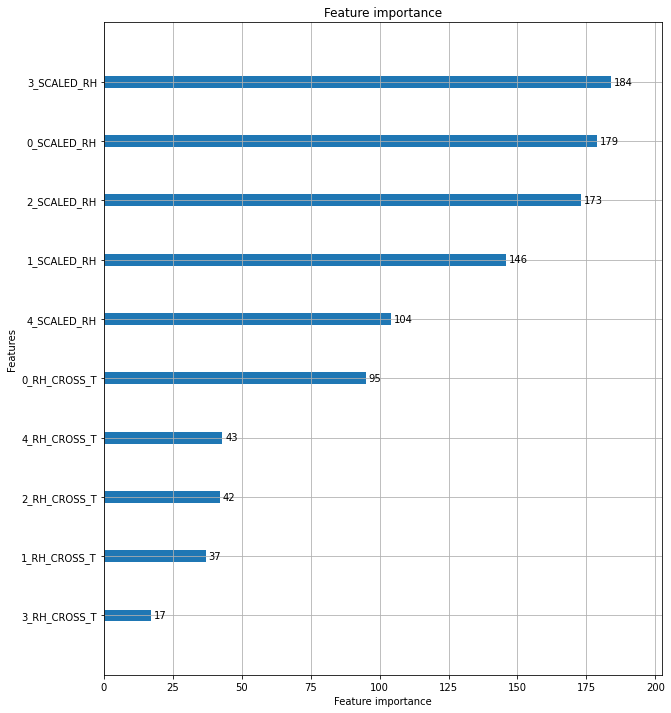

In [11]:
lgb.plot_importance(result_bst_1[0], figsize=(10, 12))

In [1]:
submission_df.to_csv("lightgbm_gbdt_split_dataset_2021_01_14_1.csv", index=False)

NameError: name 'submission_df' is not defined

In [1]:
from src.loaders.data_loader import load_train_data, load_submission_data
from src.preprocessors.splitors import split_train_valid_test_for_cv, split_x_y_for_lightgbm_train
from src.preprocessors.add_columns import add_ghi, add_rolling_mean, add_rolling_mean_bulk
from src.preprocessors.feature_engineering import feature_engineering_lightgbm
from src.preprocessors.dataset_creators import create_lightgbm_dataset
from src.make_submissions.create_submission import create_submission_using_lightgbm_model

import lightgbm as lgb
import numpy as np

In [2]:
df = load_train_data()

In [3]:
def get_lightgbm_param(q):
    param = {
            'application': 'quantile',
            'learning_rate': 0.05,
            'max_depth': 3,
            'num_leaves': 8,
            'n_jobs': 17,
            'seed': 42,
            'bagging_freq': 100,
            'feature_fraction': 0.8,
            'bagging_fraction': 0.8,
            'drop_rate': 0.2,
            'early_stopping_round': 10,
            'alpha': q,
            'boosting': 'gbdt',
        }
    return param

days = 5


In [4]:
feature_engineered_df = feature_engineering_lightgbm(df)
feature_engineered_df.head(5)

,Day,Hour,Minute,DHI,DNI,WS,RH,T,TARGET,GHI,...,DNI_rolling_mean_4,DNI_rolling_mean_8,DNI_rolling_mean_12,DNI_rolling_mean_24,DNI_rolling_mean_48,GHI_rolling_mean_4,GHI_rolling_mean_8,GHI_rolling_mean_12,GHI_rolling_mean_24,GHI_rolling_mean_48
0,0,0,0,0,0,1.5,69.08,-12,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,0,30,0,0,1.5,69.06,-12,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,1,0,0,0,1.6,71.78,-12,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,1,30,0,0,1.6,71.75,-12,0.0,0.0,...,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
4,0,2,0,0,0,1.6,75.20,-12,0.0,0.0,...,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN


In [19]:

selector = ['0_Day',
 '0_Hour',
 '0_Minute',
 '0_DHI',
 '0_DNI',
 '0_WS',
 '0_RH',
 '0_T',
 '0_TARGET',
 '0_GHI',
 '0_Day_sin',
 '0_Day_cos',
 '0_Hour_sin',
 '0_Hour_cos',
 '0_TARGET_rolling_mean_4',
 '0_TARGET_rolling_mean_8',
 '0_TARGET_rolling_mean_12',
 '0_TARGET_rolling_mean_24',
 '0_TARGET_rolling_mean_48',
 '0_DHI_rolling_mean_4',
 '0_DHI_rolling_mean_8',
 '0_DHI_rolling_mean_12',
 '0_DHI_rolling_mean_24',
 '0_DHI_rolling_mean_48',
 '0_DNI_rolling_mean_4',
 '0_DNI_rolling_mean_8',
 '0_DNI_rolling_mean_12',
 '0_DNI_rolling_mean_24',
 '0_DNI_rolling_mean_48',
 '0_GHI_rolling_mean_4',
 '0_GHI_rolling_mean_8',
 '0_GHI_rolling_mean_12',
 '0_GHI_rolling_mean_24',
 '0_GHI_rolling_mean_48',
 '1_Day',
 '1_Hour',
 '1_Minute',
 '1_DHI',
 '1_DNI',
 '1_WS',
 '1_RH',
 '1_T',
 '1_TARGET',
 '1_GHI',
 '1_Day_sin',
 '1_Day_cos',
 '1_Hour_sin',
 '1_Hour_cos',
 '1_TARGET_rolling_mean_4',
 '1_TARGET_rolling_mean_8',
 '1_TARGET_rolling_mean_12',
 '1_TARGET_rolling_mean_24',
 '1_TARGET_rolling_mean_48',
 '1_DHI_rolling_mean_4',
 '1_DHI_rolling_mean_8',
 '1_DHI_rolling_mean_12',
 '1_DHI_rolling_mean_24',
 '1_DHI_rolling_mean_48',
 '1_DNI_rolling_mean_4',
 '1_DNI_rolling_mean_8',
 '1_DNI_rolling_mean_12',
 '1_DNI_rolling_mean_24',
 '1_DNI_rolling_mean_48',
 '1_GHI_rolling_mean_4',
 '1_GHI_rolling_mean_8',
 '1_GHI_rolling_mean_12',
 '1_GHI_rolling_mean_24',
 '1_GHI_rolling_mean_48',
 '2_Day',
 '2_Hour',
 '2_Minute',
 '2_DHI',
 '2_DNI',
 '2_WS',
 '2_RH',
 '2_T',
 '2_TARGET',
 '2_GHI',
 '2_Day_sin',
 '2_Day_cos',
 '2_Hour_sin',
 '2_Hour_cos',
 '2_TARGET_rolling_mean_4',
 '2_TARGET_rolling_mean_8',
 '2_TARGET_rolling_mean_12',
 '2_TARGET_rolling_mean_24',
 '2_TARGET_rolling_mean_48',
 '2_DHI_rolling_mean_4',
 '2_DHI_rolling_mean_8',
 '2_DHI_rolling_mean_12',
 '2_DHI_rolling_mean_24',
 '2_DHI_rolling_mean_48',
 '2_DNI_rolling_mean_4',
 '2_DNI_rolling_mean_8',
 '2_DNI_rolling_mean_12',
 '2_DNI_rolling_mean_24',
 '2_DNI_rolling_mean_48',
 '2_GHI_rolling_mean_4',
 '2_GHI_rolling_mean_8',
 '2_GHI_rolling_mean_12',
 '2_GHI_rolling_mean_24',
 '2_GHI_rolling_mean_48',
 '3_Day',
 '3_Hour',
 '3_Minute',
 '3_DHI',
 '3_DNI',
 '3_WS',
 '3_RH',
 '3_T',
 '3_TARGET',
 '3_GHI',
 '3_Day_sin',
 '3_Day_cos',
 '3_Hour_sin',
 '3_Hour_cos',
 '3_TARGET_rolling_mean_4',
 '3_TARGET_rolling_mean_8',
 '3_TARGET_rolling_mean_12',
 '3_TARGET_rolling_mean_24',
 '3_TARGET_rolling_mean_48',
 '3_DHI_rolling_mean_4',
 '3_DHI_rolling_mean_8',
 '3_DHI_rolling_mean_12',
 '3_DHI_rolling_mean_24',
 '3_DHI_rolling_mean_48',
 '3_DNI_rolling_mean_4',
 '3_DNI_rolling_mean_8',
 '3_DNI_rolling_mean_12',
 '3_DNI_rolling_mean_24',
 '3_DNI_rolling_mean_48',
 '3_GHI_rolling_mean_4',
 '3_GHI_rolling_mean_8',
 '3_GHI_rolling_mean_12',
 '3_GHI_rolling_mean_24',
 '3_GHI_rolling_mean_48',
 '4_Day',
 '4_Hour',
 '4_Minute',
 '4_DHI',
 '4_DNI',
 '4_WS',
 '4_RH',
 '4_T',
 '4_TARGET',
 '4_GHI',
 '4_Day_sin',
 '4_Day_cos',
 '4_Hour_sin',
 '4_Hour_cos',
 '4_TARGET_rolling_mean_4',
 '4_TARGET_rolling_mean_8',
 '4_TARGET_rolling_mean_12',
 '4_TARGET_rolling_mean_24',
 '4_TARGET_rolling_mean_48',
 '4_DHI_rolling_mean_4',
 '4_DHI_rolling_mean_8',
 '4_DHI_rolling_mean_12',
 '4_DHI_rolling_mean_24',
 '4_DHI_rolling_mean_48',
 '4_DNI_rolling_mean_4',
 '4_DNI_rolling_mean_8',
 '4_DNI_rolling_mean_12',
 '4_DNI_rolling_mean_24',
 '4_DNI_rolling_mean_48',
 '4_GHI_rolling_mean_4',
 '4_GHI_rolling_mean_8',
 '4_GHI_rolling_mean_12',
 '4_GHI_rolling_mean_24',
 '4_GHI_rolling_mean_48']

In [20]:
history = {
    "total_error": 0,
    "submission_df": []
}

for index, (train, valid, test) in enumerate(split_train_valid_test_for_cv(feature_engineered_df, 0.5)):
    history[index] = {}
    train_1_dataset, train_2_dataset = create_lightgbm_dataset(train, days, selector)
    valid_1_dataset, valid_2_dataset = create_lightgbm_dataset(valid, days, selector)
    test_x, test_y_1, test_y_2, c = split_x_y_for_lightgbm_train(test, days)
    test_x = test_x[selector]
    submission_df = load_submission_data()
    
    for i in range(1, 10):
        q = i/10
        history[index][q] = {"bst_1": [], "bst_2": []}
        param = get_lightgbm_param(q)
        
        num_round = 5000
        bst_1 = lgb.train(param, train_1_dataset, num_round, valid_sets=[valid_1_dataset])
        bst_2 = lgb.train(param, train_2_dataset, num_round, valid_sets=[valid_2_dataset])
        
        history[index][q]["bst_1"].append(bst_1)
        history[index][q]["bst_2"].append(bst_2)
        
        y_pred_1 = bst_1.predict(test_x).reshape(-1)
        y_pred_2 = bst_2.predict(test_x).reshape(-1)

        history["total_error"] += np.sum(np.maximum(q * (test_y_1 - y_pred_1), (q - 1) * (test_y_1 - y_pred_1)))
        history["total_error"] += np.sum(np.maximum(q * (test_y_2 - y_pred_2), (q - 1) * (test_y_2 - y_pred_2)))
                
        submission_df[f"q_{q}"] = create_submission_using_lightgbm_model(selector, bst_1, bst_2, days)
    history["submission_df"].append(submission_df)

C:\Users\bees1\anaconda3\envs\dacon\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007841 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36756
[LightGBM] [Info] Number of data points in the train set: 25968, number of used features: 170
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's quantile: 1.73029
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's quantile: 1.71488
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's quantile: 1.69797
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's quantile: 1.68297
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	valid_0's quantile: 1.66326
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	valid_0's quantile: 1.64459
[Li

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[112]	valid_0's quantile: 1.35803
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[113]	valid_0's quantile: 1.35792
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[114]	valid_0's quantile: 1.35784
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[115]	valid_0's quantile: 1.35771
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[116]	valid_0's quantile: 1.35723
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[117]	valid_0's quantile: 1.35717
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[118]	valid_0's quantile: 1.35705
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[119]	valid_0's quantile: 1.35721
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[120]	valid_0's quantile: 1.35715
[LightGBM] [Warning

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006763 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36756
[LightGBM] [Info] Number of data points in the train set: 25968, number of used features: 170
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's quantile: 1.71641
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's quantile: 1.69777
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's quantile: 1.68561
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's quantile: 1.67062
[5]	valid_0's quantile: 1.65499
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	valid_0's quantile: 1.64696
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7]

[111]	valid_0's quantile: 0.673347
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[112]	valid_0's quantile: 0.667417
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[113]	valid_0's quantile: 0.663734
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[114]	valid_0's quantile: 0.662183
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[115]	valid_0's quantile: 0.656691
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[116]	valid_0's quantile: 0.651778
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[117]	valid_0's quantile: 0.64519
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[118]	valid_0's quantile: 0.639211
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[119]	valid_0's quantile: 0.635342
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[120]	valid

[216]	valid_0's quantile: 0.300634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[217]	valid_0's quantile: 0.301136
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[218]	valid_0's quantile: 0.299576
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[219]	valid_0's quantile: 0.297463
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[220]	valid_0's quantile: 0.296834
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[221]	valid_0's quantile: 0.294719
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[222]	valid_0's quantile: 0.292811
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[223]	valid_0's quantile: 0.290812
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[224]	valid_0's quantile: 0.288989
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[225]	vali

[502]	valid_0's quantile: 0.117958
[503]	valid_0's quantile: 0.116597
[504]	valid_0's quantile: 0.116596
[505]	valid_0's quantile: 0.116529
[506]	valid_0's quantile: 0.115064
[507]	valid_0's quantile: 0.114956
[508]	valid_0's quantile: 0.114833
[509]	valid_0's quantile: 0.114572
[510]	valid_0's quantile: 0.114711
[511]	valid_0's quantile: 0.11461
[512]	valid_0's quantile: 0.114732
[513]	valid_0's quantile: 0.114548
[514]	valid_0's quantile: 0.114624
[515]	valid_0's quantile: 0.114667
[516]	valid_0's quantile: 0.114602
[517]	valid_0's quantile: 0.114531
[518]	valid_0's quantile: 0.114406
[519]	valid_0's quantile: 0.114292
[520]	valid_0's quantile: 0.114167
[521]	valid_0's quantile: 0.114114
[522]	valid_0's quantile: 0.11413
[523]	valid_0's quantile: 0.11403
[524]	valid_0's quantile: 0.114167
[525]	valid_0's quantile: 0.114065
[526]	valid_0's quantile: 0.113991
[527]	valid_0's quantile: 0.113981
[528]	valid_0's quantile: 0.114166
[529]	valid_0's quantile: 0.114068
[530]	valid_0's quantil

C:\Users\bees1\anaconda3\envs\dacon\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008358 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36756
[LightGBM] [Info] Number of data points in the train set: 25968, number of used features: 170
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's quantile: 3.4341
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's quantile: 3.3819
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's quantile: 3.32747
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's quantile: 3.2698
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	valid_0's quantile: 3.21155
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	valid_0's quantile: 3.16138
[Light

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[115]	valid_0's quantile: 2.1203
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[116]	valid_0's quantile: 2.12021
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[117]	valid_0's quantile: 2.11995
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[118]	valid_0's quantile: 2.11989
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[119]	valid_0's quantile: 2.1184
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[120]	valid_0's quantile: 2.11858
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[121]	valid_0's quantile: 2.11831
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[122]	valid_0's quantile: 2.11851
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[123]	valid_0's quantile: 2.1187
[LightGBM] [Warning] N

[88]	valid_0's quantile: 0.731451
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[89]	valid_0's quantile: 0.719547
[90]	valid_0's quantile: 0.714564
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[91]	valid_0's quantile: 0.70378
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[92]	valid_0's quantile: 0.69232
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[93]	valid_0's quantile: 0.680828
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[94]	valid_0's quantile: 0.669051
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[95]	valid_0's quantile: 0.659253
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[96]	valid_0's quantile: 0.647972
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[97]	valid_0's quantile: 0.637848
[LightGBM] [Warning] No further splits with positive gain, bes

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[208]	valid_0's quantile: 0.270048
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[209]	valid_0's quantile: 0.269289
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[210]	valid_0's quantile: 0.268256
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[211]	valid_0's quantile: 0.267486
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[212]	valid_0's quantile: 0.266517
[213]	valid_0's quantile: 0.265754
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[214]	valid_0's quantile: 0.264661
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[215]	valid_0's quantile: 0.264009
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[216]	valid_0's quantile: 0.262934
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[217]	vali

[339]	valid_0's quantile: 0.216354
[340]	valid_0's quantile: 0.216411
[341]	valid_0's quantile: 0.21628
[342]	valid_0's quantile: 0.216209
[343]	valid_0's quantile: 0.216136
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[344]	valid_0's quantile: 0.216091
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[345]	valid_0's quantile: 0.215937
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[346]	valid_0's quantile: 0.215927
[347]	valid_0's quantile: 0.215763
[348]	valid_0's quantile: 0.21585
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[349]	valid_0's quantile: 0.215814
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[350]	valid_0's quantile: 0.215694
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[351]	valid_0's quantile: 0.206025
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[352]	valid_0's quanti

C:\Users\bees1\anaconda3\envs\dacon\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006918 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36756
[LightGBM] [Info] Number of data points in the train set: 25968, number of used features: 170
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's quantile: 5.1043
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's quantile: 4.9766
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's quantile: 4.83956
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's quantile: 4.7187
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	valid_0's quantile: 4.59821
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	valid_0's quantile: 4.48093
[Light

[133]	valid_0's quantile: 2.48028
[134]	valid_0's quantile: 2.4792
[135]	valid_0's quantile: 2.4794
[136]	valid_0's quantile: 2.47889
[137]	valid_0's quantile: 2.47873
[138]	valid_0's quantile: 2.47892
[139]	valid_0's quantile: 2.47884
[140]	valid_0's quantile: 2.47886
[141]	valid_0's quantile: 2.4792
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[142]	valid_0's quantile: 2.47873
[143]	valid_0's quantile: 2.47843
[144]	valid_0's quantile: 2.47818
[145]	valid_0's quantile: 2.47833
[146]	valid_0's quantile: 2.47798
[147]	valid_0's quantile: 2.47831
[148]	valid_0's quantile: 2.47836
[149]	valid_0's quantile: 2.47871
[150]	valid_0's quantile: 2.47889
[151]	valid_0's quantile: 2.4791
[152]	valid_0's quantile: 2.47905
[153]	valid_0's quantile: 2.47888
[154]	valid_0's quantile: 2.47879
[155]	valid_0's quantile: 2.47867
[156]	valid_0's quantile: 2.47868
Early stopping, best iteration is:
[146]	valid_0's quantile: 2.47798
[LightGBM] [Warning] Auto-choosing col-wise 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[229]	valid_0's quantile: 0.180747
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[230]	valid_0's quantile: 0.180494
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[231]	valid_0's quantile: 0.180312
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[232]	valid_0's quantile: 0.179948
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[233]	valid_0's quantile: 0.179603
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[234]	valid_0's quantile: 0.179352
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[235]	valid_0's quantile: 0.178989
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[236]	valid_0's quantile: 0.178775
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[237]	valid_0's quantile: 0.178594
[LightGBM]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[352]	valid_0's quantile: 0.165158
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[353]	valid_0's quantile: 0.16504
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[354]	valid_0's quantile: 0.164964
[355]	valid_0's quantile: 0.164969
[356]	valid_0's quantile: 0.164853
[357]	valid_0's quantile: 0.164775
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[358]	valid_0's quantile: 0.164702
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[359]	valid_0's quantile: 0.164564
[360]	valid_0's quantile: 0.164454
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[361]	valid_0's quantile: 0.164385
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[362]	valid_0's quantile: 0.164311
[363]	valid_0's quantile: 0.164464
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[485]	valid_0's quantile: 0.155666
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[486]	valid_0's quantile: 0.155543
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[487]	valid_0's quantile: 0.15543
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[488]	valid_0's quantile: 0.155318
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[489]	valid_0's quantile: 0.155214
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[490]	valid_0's quantile: 0.155121
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[491]	valid_0's quantile: 0.155122
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[492]	valid_0's quantile: 0.1551
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[493]	valid_0's quantile: 0.155006
[LightGBM] [W

[779]	valid_0's quantile: 0.130329
[780]	valid_0's quantile: 0.130323
[781]	valid_0's quantile: 0.130328
[782]	valid_0's quantile: 0.130314
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[783]	valid_0's quantile: 0.13022
[784]	valid_0's quantile: 0.1302
[785]	valid_0's quantile: 0.130094
[786]	valid_0's quantile: 0.130082
[787]	valid_0's quantile: 0.130057
[788]	valid_0's quantile: 0.130082
[789]	valid_0's quantile: 0.129932
[790]	valid_0's quantile: 0.129844
[791]	valid_0's quantile: 0.12989
[792]	valid_0's quantile: 0.129879
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[793]	valid_0's quantile: 0.129865
[794]	valid_0's quantile: 0.129859
[795]	valid_0's quantile: 0.129824
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[796]	valid_0's quantile: 0.12984
[797]	valid_0's quantile: 0.129875
[798]	valid_0's quantile: 0.129837
[799]	valid_0's quantile: 0.129788
[800]	valid_0's quantile: 0.129608
[LightGBM]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[913]	valid_0's quantile: 0.120732
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[914]	valid_0's quantile: 0.1207
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[915]	valid_0's quantile: 0.120685
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[916]	valid_0's quantile: 0.120698
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[917]	valid_0's quantile: 0.120654
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[918]	valid_0's quantile: 0.120661
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[919]	valid_0's quantile: 0.120628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[920]	valid_0's quantile: 0.120627
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[921]	valid_0's quantile: 0.120613
[LightGBM] [

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1044]	valid_0's quantile: 0.113729
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1045]	valid_0's quantile: 0.113694
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1046]	valid_0's quantile: 0.113688
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1047]	valid_0's quantile: 0.113668
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1048]	valid_0's quantile: 0.113644
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1049]	valid_0's quantile: 0.113607
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1050]	valid_0's quantile: 0.11361
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1051]	valid_0's quantile: 0.113579
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1052]	valid_0's quantile: 0.113573
[L

[1187]	valid_0's quantile: 0.109086
[1188]	valid_0's quantile: 0.10907
[1189]	valid_0's quantile: 0.109018
[1190]	valid_0's quantile: 0.108963
[1191]	valid_0's quantile: 0.108965
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1192]	valid_0's quantile: 0.108943
[1193]	valid_0's quantile: 0.108953
[1194]	valid_0's quantile: 0.108938
[1195]	valid_0's quantile: 0.108927
[1196]	valid_0's quantile: 0.108933
[1197]	valid_0's quantile: 0.108935
[1198]	valid_0's quantile: 0.108944
[1199]	valid_0's quantile: 0.108961
[1200]	valid_0's quantile: 0.108953
[1201]	valid_0's quantile: 0.108926
[1202]	valid_0's quantile: 0.108908
[1203]	valid_0's quantile: 0.108919
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1204]	valid_0's quantile: 0.108936
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1205]	valid_0's quantile: 0.108916
[1206]	valid_0's quantile: 0.108933
[LightGBM] [Warning] No further splits with positive gai

C:\Users\bees1\anaconda3\envs\dacon\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008530 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36756
[LightGBM] [Info] Number of data points in the train set: 25968, number of used features: 170
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's quantile: 6.73679
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's quantile: 6.49575
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's quantile: 6.26419
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's quantile: 6.05029
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	valid_0's quantile: 5.86101
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	valid_0's quantile: 5.66672
[Li

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[122]	valid_0's quantile: 2.57754
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[123]	valid_0's quantile: 2.57836
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[124]	valid_0's quantile: 2.57759
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[125]	valid_0's quantile: 2.57647
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[126]	valid_0's quantile: 2.57667
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[127]	valid_0's quantile: 2.5766
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[128]	valid_0's quantile: 2.57588
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[129]	valid_0's quantile: 2.57549
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[130]	valid_0's quantile: 2.57533
[LightGBM] [Warning]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[102]	valid_0's quantile: 0.443402
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[103]	valid_0's quantile: 0.439119
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[104]	valid_0's quantile: 0.434862
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[105]	valid_0's quantile: 0.430945
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[106]	valid_0's quantile: 0.427767
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[107]	valid_0's quantile: 0.424062
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[108]	valid_0's quantile: 0.423388
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[109]	valid_0's quantile: 0.420919
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[110]	valid_0's quantile: 0.417657
[LightGBM]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[237]	valid_0's quantile: 0.336561
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[238]	valid_0's quantile: 0.336599
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[239]	valid_0's quantile: 0.336739
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[240]	valid_0's quantile: 0.336583
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[241]	valid_0's quantile: 0.336404
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[242]	valid_0's quantile: 0.336434
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[243]	valid_0's quantile: 0.336618
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[244]	valid_0's quantile: 0.336528
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[245]	valid_0's quantile: 0.336555
[LightGBM]

C:\Users\bees1\anaconda3\envs\dacon\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008099 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36756
[LightGBM] [Info] Number of data points in the train set: 25968, number of used features: 170
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's quantile: 8.32962
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's quantile: 7.95905
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's quantile: 7.61601
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's quantile: 7.2873
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	valid_0's quantile: 6.98343
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	valid_0's quantile: 6.70152
[Lig

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[118]	valid_0's quantile: 2.50684
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[119]	valid_0's quantile: 2.50535
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[120]	valid_0's quantile: 2.50428
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[121]	valid_0's quantile: 2.50198
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[122]	valid_0's quantile: 2.49941
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[123]	valid_0's quantile: 2.49902
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[124]	valid_0's quantile: 2.49757
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[125]	valid_0's quantile: 2.49708
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[126]	valid_0's quantile: 2.49612
[LightGBM] [Warning

[76]	valid_0's quantile: 0.405614
[77]	valid_0's quantile: 0.395684
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[78]	valid_0's quantile: 0.386368
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[79]	valid_0's quantile: 0.377548
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[80]	valid_0's quantile: 0.369279
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[81]	valid_0's quantile: 0.361383
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[82]	valid_0's quantile: 0.354001
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[83]	valid_0's quantile: 0.351548
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[84]	valid_0's quantile: 0.344538
[85]	valid_0's quantile: 0.337938
[86]	valid_0's quantile: 0.332949
[87]	valid_0's quantile: 0.327035
[88]	valid_0's quantile: 0.321275
[LightGBM] [Warning] No further s

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[218]	valid_0's quantile: 0.191451
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[219]	valid_0's quantile: 0.191376
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[220]	valid_0's quantile: 0.191284
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[221]	valid_0's quantile: 0.191085
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[222]	valid_0's quantile: 0.191049
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[223]	valid_0's quantile: 0.191015
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[224]	valid_0's quantile: 0.191015
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[225]	valid_0's quantile: 0.190729
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[226]	valid_0's quantile: 0.190668
[LightGBM]

[346]	valid_0's quantile: 0.169024
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[347]	valid_0's quantile: 0.168749
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[348]	valid_0's quantile: 0.168579
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[349]	valid_0's quantile: 0.168378
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[350]	valid_0's quantile: 0.168124
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[351]	valid_0's quantile: 0.168075
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[352]	valid_0's quantile: 0.167966
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[353]	valid_0's quantile: 0.167799
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[354]	valid_0's quantile: 0.167641
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[355]	vali

[468]	valid_0's quantile: 0.153116
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[469]	valid_0's quantile: 0.153018
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[470]	valid_0's quantile: 0.152984
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[471]	valid_0's quantile: 0.152958
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[472]	valid_0's quantile: 0.152946
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[473]	valid_0's quantile: 0.152719
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[474]	valid_0's quantile: 0.152583
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[475]	valid_0's quantile: 0.152476
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[476]	valid_0's quantile: 0.152426
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[477]	vali

[594]	valid_0's quantile: 0.14566
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[595]	valid_0's quantile: 0.145558
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[596]	valid_0's quantile: 0.145508
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[597]	valid_0's quantile: 0.145426
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[598]	valid_0's quantile: 0.145319
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[599]	valid_0's quantile: 0.145306
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[600]	valid_0's quantile: 0.145268
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[601]	valid_0's quantile: 0.145168
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[602]	valid_0's quantile: 0.145105
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[603]	valid

C:\Users\bees1\anaconda3\envs\dacon\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007975 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36756
[LightGBM] [Info] Number of data points in the train set: 25968, number of used features: 170
[LightGBM] [Info] Start training from score 9.289532
[1]	valid_0's quantile: 9.6506
Training until validation scores don't improve for 10 rounds
[2]	valid_0's quantile: 9.16901
[3]	valid_0's quantile: 8.72448
[4]	valid_0's quantile: 8.31046
[5]	valid_0's quantile: 7.93022
[6]	valid_0's quantile: 7.57296
[7]	valid_0's quantile: 7.23185
[8]	valid_0's quantile: 6.93035
[9]	valid_0's quantile: 6.63845
[10]	valid_0's quantile: 6.36894
[11]	valid_0's quantile: 6.11304
[12]	valid_0's quantile: 5.87635
[13]	valid_0's quantile: 5.65374
[14]	valid_0's quantile: 5.44746
[15]	valid_0's quantile: 5.25713
[16]	valid_0's quantile: 5.08136
[17]	valid_0's quantile: 4.9127
[18]	valid_0's quantile: 4.75521
[19]	vali

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[126]	valid_0's quantile: 2.22951
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[127]	valid_0's quantile: 2.2288
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[128]	valid_0's quantile: 2.22756
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[129]	valid_0's quantile: 2.22695
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[130]	valid_0's quantile: 2.22609
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[131]	valid_0's quantile: 2.22571
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[132]	valid_0's quantile: 2.22582
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[133]	valid_0's quantile: 2.22555
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[134]	valid_0's quantile: 2.22441
[LightGBM] [Warning]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[58]	valid_0's quantile: 0.556399
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[59]	valid_0's quantile: 0.543516
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[60]	valid_0's quantile: 0.528163
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[61]	valid_0's quantile: 0.512928
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[62]	valid_0's quantile: 0.499661
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[63]	valid_0's quantile: 0.486637
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[64]	valid_0's quantile: 0.475025
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[65]	valid_0's quantile: 0.463054
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[66]	valid_0's quantile: 0.453195
[LightGBM] [Warning

[183]	valid_0's quantile: 0.282756
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[184]	valid_0's quantile: 0.282402
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[185]	valid_0's quantile: 0.281306
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[186]	valid_0's quantile: 0.280203
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[187]	valid_0's quantile: 0.280349
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[188]	valid_0's quantile: 0.280374
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[189]	valid_0's quantile: 0.280067
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[190]	valid_0's quantile: 0.279913
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[191]	valid_0's quantile: 0.279638
[192]	valid_0's quantile: 0.279889
[LightGBM] [Warning] No further splits with positi

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[312]	valid_0's quantile: 0.259966
Early stopping, best iteration is:
[302]	valid_0's quantile: 0.259831


C:\Users\bees1\anaconda3\envs\dacon\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006989 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36756
[LightGBM] [Info] Number of data points in the train set: 25968, number of used features: 170
[LightGBM] [Info] Start training from score 23.458515
[1]	valid_0's quantile: 9.82615
Training until validation scores don't improve for 10 rounds
[2]	valid_0's quantile: 9.32114
[3]	valid_0's quantile: 8.85739
[4]	valid_0's quantile: 8.40515
[5]	valid_0's quantile: 7.99147
[6]	valid_0's quantile: 7.6055
[7]	valid_0's quantile: 7.24144
[8]	valid_0's quantile: 6.90155
[9]	valid_0's quantile: 6.59869
[10]	valid_0's quantile: 6.30951
[11]	valid_0's quantile: 6.04349
[12]	valid_0's quantile: 5.79231
[13]	valid_0's quantile: 5.55307
[14]	valid_0's quantile: 5.33102
[15]	valid_0's quantile: 5.1312
[16]	valid_0's quantile: 4.94068
[17]	valid_0's quantile: 4.76037
[18]	valid_0's quantile: 4.59159
[19]	val

[115]	valid_0's quantile: 1.83992
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[116]	valid_0's quantile: 1.83707
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[117]	valid_0's quantile: 1.8361
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[118]	valid_0's quantile: 1.83511
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[119]	valid_0's quantile: 1.83245
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[120]	valid_0's quantile: 1.83051
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[121]	valid_0's quantile: 1.82997
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[122]	valid_0's quantile: 1.82908
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[123]	valid_0's quantile: 1.82844
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[124]	valid_0's quan

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[224]	valid_0's quantile: 1.78452
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[225]	valid_0's quantile: 1.78461
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[226]	valid_0's quantile: 1.78495
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[227]	valid_0's quantile: 1.78478
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[228]	valid_0's quantile: 1.78513
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[229]	valid_0's quantile: 1.78564
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[230]	valid_0's quantile: 1.78577
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[231]	valid_0's quantile: 1.78658
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[232]	valid_0's quantile: 1.78661
[LightGBM] [Warning

[113]	valid_0's quantile: 0.198145
[114]	valid_0's quantile: 0.197419
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[115]	valid_0's quantile: 0.196736
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[116]	valid_0's quantile: 0.195774
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[117]	valid_0's quantile: 0.195544
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[118]	valid_0's quantile: 0.195329
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[119]	valid_0's quantile: 0.195128
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[120]	valid_0's quantile: 0.194508
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[121]	valid_0's quantile: 0.194352
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[122]	valid_0's quantile: 0.193558
[123]	valid_0's quantile: 0.192482
[LightGBM] [War

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[246]	valid_0's quantile: 0.160217
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[247]	valid_0's quantile: 0.15921
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[248]	valid_0's quantile: 0.159236
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[249]	valid_0's quantile: 0.15925
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[250]	valid_0's quantile: 0.159219
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[251]	valid_0's quantile: 0.15919
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[252]	valid_0's quantile: 0.159154
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[253]	valid_0's quantile: 0.159099
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[254]	valid_0's quantile: 0.158304
[LightGBM] [W

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[367]	valid_0's quantile: 0.144668
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[368]	valid_0's quantile: 0.144605
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[369]	valid_0's quantile: 0.144455
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[370]	valid_0's quantile: 0.144303
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[371]	valid_0's quantile: 0.144165
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[372]	valid_0's quantile: 0.144077
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[373]	valid_0's quantile: 0.144006
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[374]	valid_0's quantile: 0.143951
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[375]	valid_0's quantile: 0.143853
[LightGBM]

[468]	valid_0's quantile: 0.137972
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[469]	valid_0's quantile: 0.137948
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[470]	valid_0's quantile: 0.137926
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[471]	valid_0's quantile: 0.137887
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[472]	valid_0's quantile: 0.137783
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[473]	valid_0's quantile: 0.137708
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[474]	valid_0's quantile: 0.137777
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[475]	valid_0's quantile: 0.137775
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[476]	valid_0's quantile: 0.13763
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[477]	valid

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[580]	valid_0's quantile: 0.134075
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[581]	valid_0's quantile: 0.134011
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[582]	valid_0's quantile: 0.133963
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[583]	valid_0's quantile: 0.13392
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[584]	valid_0's quantile: 0.13384
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[585]	valid_0's quantile: 0.133811
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[586]	valid_0's quantile: 0.133784
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[587]	valid_0's quantile: 0.133783
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[588]	valid_0's quantile: 0.133745
[LightGBM] [

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[705]	valid_0's quantile: 0.129179
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[706]	valid_0's quantile: 0.129098
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[707]	valid_0's quantile: 0.129091
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[708]	valid_0's quantile: 0.129098
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[709]	valid_0's quantile: 0.129141
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[710]	valid_0's quantile: 0.129089
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[711]	valid_0's quantile: 0.12901
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[712]	valid_0's quantile: 0.129014
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[713]	valid_0's quantile: 0.12901
[LightGBM] [

[812]	valid_0's quantile: 0.126577
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[813]	valid_0's quantile: 0.126573
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[814]	valid_0's quantile: 0.126571
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[815]	valid_0's quantile: 0.126531
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[816]	valid_0's quantile: 0.126539
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[817]	valid_0's quantile: 0.126539
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[818]	valid_0's quantile: 0.126531
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[819]	valid_0's quantile: 0.126525
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[820]	valid_0's quantile: 0.126521
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[821]	vali

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[920]	valid_0's quantile: 0.123966
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[921]	valid_0's quantile: 0.123946
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[922]	valid_0's quantile: 0.123944
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[923]	valid_0's quantile: 0.123853
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[924]	valid_0's quantile: 0.123854
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[925]	valid_0's quantile: 0.123842
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[926]	valid_0's quantile: 0.123833
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[927]	valid_0's quantile: 0.123808
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[928]	valid_0's quantile: 0.123801
[LightGBM]

[1041]	valid_0's quantile: 0.121842
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1042]	valid_0's quantile: 0.121847
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1043]	valid_0's quantile: 0.121845
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1044]	valid_0's quantile: 0.121845
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1045]	valid_0's quantile: 0.121844
[1046]	valid_0's quantile: 0.121884
[1047]	valid_0's quantile: 0.121865
Early stopping, best iteration is:
[1037]	valid_0's quantile: 0.121838


C:\Users\bees1\anaconda3\envs\dacon\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008700 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36756
[LightGBM] [Info] Number of data points in the train set: 25968, number of used features: 170
[LightGBM] [Info] Start training from score 41.104828
[1]	valid_0's quantile: 8.50364
Training until validation scores don't improve for 10 rounds
[2]	valid_0's quantile: 8.06591
[3]	valid_0's quantile: 7.666
[4]	valid_0's quantile: 7.30116
[5]	valid_0's quantile: 6.94805
[6]	valid_0's quantile: 6.60863
[7]	valid_0's quantile: 6.27989
[8]	valid_0's quantile: 5.9778
[9]	valid_0's quantile: 5.7106
[10]	valid_0's quantile: 5.44813
[11]	valid_0's quantile: 5.19932
[12]	valid_0's quantile: 4.97307
[13]	valid_0's quantile: 4.76491
[14]	valid_0's quantile: 4.561
[15]	valid_0's quantile: 4.37089
[16]	valid_0's quantile: 4.19354
[17]	valid_0's quantile: 4.02672
[18]	valid_0's quantile: 3.86792
[19]	valid_0

[11]	valid_0's quantile: 4.78067
[12]	valid_0's quantile: 4.52564
[13]	valid_0's quantile: 4.28281
[14]	valid_0's quantile: 4.05379
[15]	valid_0's quantile: 3.83679
[16]	valid_0's quantile: 3.63125
[17]	valid_0's quantile: 3.44142
[18]	valid_0's quantile: 3.2562
[19]	valid_0's quantile: 3.08672
[20]	valid_0's quantile: 2.92206
[21]	valid_0's quantile: 2.76512
[22]	valid_0's quantile: 2.62514
[23]	valid_0's quantile: 2.49002
[24]	valid_0's quantile: 2.35679
[25]	valid_0's quantile: 2.23496
[26]	valid_0's quantile: 2.11518
[27]	valid_0's quantile: 2.00119
[28]	valid_0's quantile: 1.89374
[29]	valid_0's quantile: 1.79259
[30]	valid_0's quantile: 1.69744
[31]	valid_0's quantile: 1.61412
[32]	valid_0's quantile: 1.52974
[33]	valid_0's quantile: 1.45176
[34]	valid_0's quantile: 1.37827
[35]	valid_0's quantile: 1.30964
[36]	valid_0's quantile: 1.24489
[37]	valid_0's quantile: 1.18447
[38]	valid_0's quantile: 1.12654
[39]	valid_0's quantile: 1.07761
[40]	valid_0's quantile: 1.02729
[41]	valid_

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[142]	valid_0's quantile: 0.178608
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[143]	valid_0's quantile: 0.177841
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[144]	valid_0's quantile: 0.177449
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[145]	valid_0's quantile: 0.177211
[146]	valid_0's quantile: 0.177007
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[147]	valid_0's quantile: 0.176309
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[148]	valid_0's quantile: 0.17575
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[149]	valid_0's quantile: 0.175533
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[150]	valid_0's quantile: 0.175146
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[151]	valid

[247]	valid_0's quantile: 0.155043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[248]	valid_0's quantile: 0.154963
[249]	valid_0's quantile: 0.154946
[250]	valid_0's quantile: 0.154886
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[251]	valid_0's quantile: 0.15488
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[252]	valid_0's quantile: 0.154824
[253]	valid_0's quantile: 0.15477
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[254]	valid_0's quantile: 0.154517
[255]	valid_0's quantile: 0.154399
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[256]	valid_0's quantile: 0.15426
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[257]	valid_0's quantile: 0.154184
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[258]	valid_0's quantile: 0.154125
[LightGBM] [Warning] No further splits with positive gain,

[369]	valid_0's quantile: 0.147055
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[370]	valid_0's quantile: 0.147038
[371]	valid_0's quantile: 0.146969
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[372]	valid_0's quantile: 0.146953
[373]	valid_0's quantile: 0.146909
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[374]	valid_0's quantile: 0.146884
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[375]	valid_0's quantile: 0.146878
[376]	valid_0's quantile: 0.146795
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[377]	valid_0's quantile: 0.146787
[378]	valid_0's quantile: 0.146731
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[379]	valid_0's quantile: 0.14671
[380]	valid_0's quantile: 0.146682
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[381]	valid_0's quantile: 0.146657
[382]	valid_0's quant

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[486]	valid_0's quantile: 0.142153
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[487]	valid_0's quantile: 0.142146
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[488]	valid_0's quantile: 0.14213
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[489]	valid_0's quantile: 0.142102
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[490]	valid_0's quantile: 0.142075
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[491]	valid_0's quantile: 0.14203
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[492]	valid_0's quantile: 0.141999
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[493]	valid_0's quantile: 0.141978
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[494]	valid_0's quantile: 0.14198
[LightGBM] [W

[599]	valid_0's quantile: 0.139505
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[600]	valid_0's quantile: 0.139495
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[601]	valid_0's quantile: 0.139469
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[602]	valid_0's quantile: 0.139444
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[603]	valid_0's quantile: 0.139414
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[604]	valid_0's quantile: 0.139391
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[605]	valid_0's quantile: 0.139367
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[606]	valid_0's quantile: 0.139356
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[607]	valid_0's quantile: 0.139361
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[608]	vali

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[727]	valid_0's quantile: 0.136145
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[728]	valid_0's quantile: 0.136133
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[729]	valid_0's quantile: 0.136121
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[730]	valid_0's quantile: 0.136109
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[731]	valid_0's quantile: 0.136094
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[732]	valid_0's quantile: 0.135998
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[733]	valid_0's quantile: 0.135919
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[734]	valid_0's quantile: 0.135827
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[735]	valid_0's quantile: 0.135823
[LightGBM]

[861]	valid_0's quantile: 0.131933
[862]	valid_0's quantile: 0.131935
[863]	valid_0's quantile: 0.13193
[864]	valid_0's quantile: 0.131932
[865]	valid_0's quantile: 0.131928
[866]	valid_0's quantile: 0.131931
[867]	valid_0's quantile: 0.13193
[868]	valid_0's quantile: 0.131923
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[869]	valid_0's quantile: 0.131924
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[870]	valid_0's quantile: 0.131909
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[871]	valid_0's quantile: 0.131908
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[872]	valid_0's quantile: 0.131849
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[873]	valid_0's quantile: 0.131848
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[874]	valid_0's quantile: 0.131829
[LightGBM] [Warning] No further splits with positive gain, bes

C:\Users\bees1\anaconda3\envs\dacon\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007157 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36756
[LightGBM] [Info] Number of data points in the train set: 25968, number of used features: 170
[LightGBM] [Info] Start training from score 61.831615
[1]	valid_0's quantile: 5.5679
Training until validation scores don't improve for 10 rounds
[2]	valid_0's quantile: 5.38736
[3]	valid_0's quantile: 5.23369
[4]	valid_0's quantile: 5.08136
[5]	valid_0's quantile: 4.92801
[6]	valid_0's quantile: 4.78221
[7]	valid_0's quantile: 4.64693
[8]	valid_0's quantile: 4.51993
[9]	valid_0's quantile: 4.39913
[10]	valid_0's quantile: 4.29453
[11]	valid_0's quantile: 4.18015
[12]	valid_0's quantile: 4.0613
[13]	valid_0's quantile: 3.95277
[14]	valid_0's quantile: 3.84879
[15]	valid_0's quantile: 3.73612
[16]	valid_0's quantile: 3.63688
[17]	valid_0's quantile: 3.5291
[18]	valid_0's quantile: 3.41571
[19]	vali

[129]	valid_0's quantile: 0.735249
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[130]	valid_0's quantile: 0.734785
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[131]	valid_0's quantile: 0.734228
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[132]	valid_0's quantile: 0.733408
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[133]	valid_0's quantile: 0.732549
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[134]	valid_0's quantile: 0.731878
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[135]	valid_0's quantile: 0.731248
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[136]	valid_0's quantile: 0.730841
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[137]	valid_0's quantile: 0.730391
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[138]	vali

[269]	valid_0's quantile: 0.709662
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[270]	valid_0's quantile: 0.709511
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[271]	valid_0's quantile: 0.709514
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[272]	valid_0's quantile: 0.709524
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[273]	valid_0's quantile: 0.709518
[274]	valid_0's quantile: 0.709498
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[275]	valid_0's quantile: 0.709523
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[276]	valid_0's quantile: 0.709503
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[277]	valid_0's quantile: 0.709397
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[278]	valid_0's quantile: 0.709373
[LightGBM] [Warning] No further splits with positi

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[57]	valid_0's quantile: 1.09959
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[58]	valid_0's quantile: 1.06756
[59]	valid_0's quantile: 1.0334
[60]	valid_0's quantile: 1.00092
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[61]	valid_0's quantile: 0.968479
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[62]	valid_0's quantile: 0.9422
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[63]	valid_0's quantile: 0.917092
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[64]	valid_0's quantile: 0.890933
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[65]	valid_0's quantile: 0.869706
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[66]	valid_0's quantile: 0.84509
[LightGBM] [Warning] No further splits with positive gain, best gain

[196]	valid_0's quantile: 0.164587
[197]	valid_0's quantile: 0.164165
[198]	valid_0's quantile: 0.163723
[199]	valid_0's quantile: 0.162977
[200]	valid_0's quantile: 0.162264
[201]	valid_0's quantile: 0.161887
[202]	valid_0's quantile: 0.161769
[203]	valid_0's quantile: 0.161431
[204]	valid_0's quantile: 0.161178
[205]	valid_0's quantile: 0.160126
[206]	valid_0's quantile: 0.159071
[207]	valid_0's quantile: 0.157979
[208]	valid_0's quantile: 0.157778
[209]	valid_0's quantile: 0.157714
[210]	valid_0's quantile: 0.157539
[211]	valid_0's quantile: 0.15744
[212]	valid_0's quantile: 0.157359
[213]	valid_0's quantile: 0.157288
[214]	valid_0's quantile: 0.157214
[215]	valid_0's quantile: 0.157144
[216]	valid_0's quantile: 0.157038
[217]	valid_0's quantile: 0.156909
[218]	valid_0's quantile: 0.15685
[219]	valid_0's quantile: 0.156752
[220]	valid_0's quantile: 0.156548
[221]	valid_0's quantile: 0.156489
[222]	valid_0's quantile: 0.156439
[223]	valid_0's quantile: 0.156392
[224]	valid_0's quanti

C:\Users\bees1\anaconda3\envs\dacon\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008092 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36782
[LightGBM] [Info] Number of data points in the train set: 25968, number of used features: 170
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's quantile: 1.83107
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's quantile: 1.81867
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's quantile: 1.8047
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's quantile: 1.78586
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	valid_0's quantile: 1.7737
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	valid_0's quantile: 1.75771
[Ligh

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[83]	valid_0's quantile: 1.48979
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[84]	valid_0's quantile: 1.48992
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[85]	valid_0's quantile: 1.49001
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[86]	valid_0's quantile: 1.4901
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[87]	valid_0's quantile: 1.4903
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[88]	valid_0's quantile: 1.49047
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[89]	valid_0's quantile: 1.49047
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[90]	valid_0's quantile: 1.48984
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[91]	valid_0's quantile: 1.4899
[LightGBM] [Warning] No further

[149]	valid_0's quantile: 0.470823
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[150]	valid_0's quantile: 0.465919
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[151]	valid_0's quantile: 0.461257
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[152]	valid_0's quantile: 0.456384
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[153]	valid_0's quantile: 0.455314
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[154]	valid_0's quantile: 0.450576
[155]	valid_0's quantile: 0.4461
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[156]	valid_0's quantile: 0.441693
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[157]	valid_0's quantile: 0.437156
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[158]	valid_0's quantile: 0.432883
[LightGBM] [Warning] No further splits with positive

[294]	valid_0's quantile: 0.141362
[295]	valid_0's quantile: 0.13998
[296]	valid_0's quantile: 0.138676
[297]	valid_0's quantile: 0.138483
[298]	valid_0's quantile: 0.137241
[299]	valid_0's quantile: 0.135874
[300]	valid_0's quantile: 0.134602
[301]	valid_0's quantile: 0.13347
[302]	valid_0's quantile: 0.132146
[303]	valid_0's quantile: 0.130909
[304]	valid_0's quantile: 0.129735
[305]	valid_0's quantile: 0.129512
[306]	valid_0's quantile: 0.12861
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[307]	valid_0's quantile: 0.127561
[308]	valid_0's quantile: 0.126573
[309]	valid_0's quantile: 0.125616
[310]	valid_0's quantile: 0.12472
[311]	valid_0's quantile: 0.123859
[312]	valid_0's quantile: 0.122766
[313]	valid_0's quantile: 0.121736
[314]	valid_0's quantile: 0.12075
[315]	valid_0's quantile: 0.120019
[316]	valid_0's quantile: 0.119116
[317]	valid_0's quantile: 0.118139
[318]	valid_0's quantile: 0.117344
[319]	valid_0's quantile: 0.117163
[320]	valid_0's quan

[429]	valid_0's quantile: 0.0703697
[430]	valid_0's quantile: 0.0701175
[431]	valid_0's quantile: 0.0698821
[432]	valid_0's quantile: 0.0697408
[433]	valid_0's quantile: 0.0695156
[434]	valid_0's quantile: 0.0692807
[435]	valid_0's quantile: 0.0688969
[436]	valid_0's quantile: 0.0685217
[437]	valid_0's quantile: 0.0681785
[438]	valid_0's quantile: 0.0678484
[439]	valid_0's quantile: 0.0675402
[440]	valid_0's quantile: 0.0672905
[441]	valid_0's quantile: 0.0669542
[442]	valid_0's quantile: 0.0668985
[443]	valid_0's quantile: 0.0668666
[444]	valid_0's quantile: 0.0666084
[445]	valid_0's quantile: 0.0663475
[446]	valid_0's quantile: 0.066114
[447]	valid_0's quantile: 0.0658908
[448]	valid_0's quantile: 0.0657688
[449]	valid_0's quantile: 0.0657373
[450]	valid_0's quantile: 0.0655343
[451]	valid_0's quantile: 0.0653444
[452]	valid_0's quantile: 0.0651701
[453]	valid_0's quantile: 0.0650587
[454]	valid_0's quantile: 0.064803
[455]	valid_0's quantile: 0.0645749
[456]	valid_0's quantile: 0.06

[719]	valid_0's quantile: 0.0448569
[720]	valid_0's quantile: 0.0448433
[721]	valid_0's quantile: 0.044784
[722]	valid_0's quantile: 0.0447245
[723]	valid_0's quantile: 0.0447151
[724]	valid_0's quantile: 0.0446656
[725]	valid_0's quantile: 0.0446346
[726]	valid_0's quantile: 0.0446272
[727]	valid_0's quantile: 0.0446001
[728]	valid_0's quantile: 0.0445837
[729]	valid_0's quantile: 0.0445849
[730]	valid_0's quantile: 0.0445509
[731]	valid_0's quantile: 0.0445098
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[732]	valid_0's quantile: 0.044506
[733]	valid_0's quantile: 0.0445058
[734]	valid_0's quantile: 0.0444583
[735]	valid_0's quantile: 0.0444119
[736]	valid_0's quantile: 0.0443704
[737]	valid_0's quantile: 0.0443685
[738]	valid_0's quantile: 0.0443532
[739]	valid_0's quantile: 0.0443373
[740]	valid_0's quantile: 0.0443358
[741]	valid_0's quantile: 0.0442721
[742]	valid_0's quantile: 0.0442469
[743]	valid_0's quantile: 0.0442297
[744]	valid_0's quantile: 0

[1012]	valid_0's quantile: 0.0397063
[1013]	valid_0's quantile: 0.0396978
[1014]	valid_0's quantile: 0.0396853
[1015]	valid_0's quantile: 0.0396749
[1016]	valid_0's quantile: 0.0396432
[1017]	valid_0's quantile: 0.0396401
[1018]	valid_0's quantile: 0.0396153
[1019]	valid_0's quantile: 0.0395916
[1020]	valid_0's quantile: 0.03958
[1021]	valid_0's quantile: 0.0395695
[1022]	valid_0's quantile: 0.0395377
[1023]	valid_0's quantile: 0.0395269
[1024]	valid_0's quantile: 0.0395052
[1025]	valid_0's quantile: 0.0394706
[1026]	valid_0's quantile: 0.0394722
[1027]	valid_0's quantile: 0.039454
[1028]	valid_0's quantile: 0.0394362
[1029]	valid_0's quantile: 0.0394335
[1030]	valid_0's quantile: 0.0394285
[1031]	valid_0's quantile: 0.0394294
[1032]	valid_0's quantile: 0.0393918
[1033]	valid_0's quantile: 0.039386
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1034]	valid_0's quantile: 0.0393877
[1035]	valid_0's quantile: 0.039384
[1036]	valid_0's quantile: 0.0393667
[1037

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1284]	valid_0's quantile: 0.0375826
[1285]	valid_0's quantile: 0.0375814
[1286]	valid_0's quantile: 0.03758
[1287]	valid_0's quantile: 0.0375799
[1288]	valid_0's quantile: 0.0375795
[1289]	valid_0's quantile: 0.0375835
[1290]	valid_0's quantile: 0.0375668
[1291]	valid_0's quantile: 0.0375562
[1292]	valid_0's quantile: 0.0375497
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1293]	valid_0's quantile: 0.0375504
[1294]	valid_0's quantile: 0.0375513
[1295]	valid_0's quantile: 0.0375496
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1296]	valid_0's quantile: 0.0375503
[1297]	valid_0's quantile: 0.0375282
[1298]	valid_0's quantile: 0.0375295
[1299]	valid_0's quantile: 0.0375267
[1300]	valid_0's quantile: 0.0375241
[1301]	valid_0's quantile: 0.0374975
[1302]	valid_0's quantile: 0.0374737
[1303]	valid_0's quantile: 0.0374482
[1304]	valid_0's quantile: 0.0374404


C:\Users\bees1\anaconda3\envs\dacon\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007220 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36782
[LightGBM] [Info] Number of data points in the train set: 25968, number of used features: 170
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's quantile: 3.63352
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's quantile: 3.57625
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's quantile: 3.5234
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's quantile: 3.46831
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	valid_0's quantile: 3.41151
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	valid_0's quantile: 3.3552
[Ligh

[39]	valid_0's quantile: 1.87897
[40]	valid_0's quantile: 1.84931
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[41]	valid_0's quantile: 1.81746
[42]	valid_0's quantile: 1.78719
[43]	valid_0's quantile: 1.75688
[44]	valid_0's quantile: 1.72677
[45]	valid_0's quantile: 1.69648
[46]	valid_0's quantile: 1.66883
[47]	valid_0's quantile: 1.63509
[48]	valid_0's quantile: 1.60695
[49]	valid_0's quantile: 1.5799
[50]	valid_0's quantile: 1.54935
[51]	valid_0's quantile: 1.51945
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[52]	valid_0's quantile: 1.49192
[53]	valid_0's quantile: 1.46631
[54]	valid_0's quantile: 1.44088
[55]	valid_0's quantile: 1.41562
[56]	valid_0's quantile: 1.39145
[57]	valid_0's quantile: 1.36823
[58]	valid_0's quantile: 1.34586
[59]	valid_0's quantile: 1.321
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[60]	valid_0's quantile: 1.29893
[61]	valid_0's quantile: 1.27708
[62]	valid_0's quan

[337]	valid_0's quantile: 0.10847
[338]	valid_0's quantile: 0.108414
[339]	valid_0's quantile: 0.107814
[340]	valid_0's quantile: 0.107223
[341]	valid_0's quantile: 0.107068
[342]	valid_0's quantile: 0.106902
[343]	valid_0's quantile: 0.106802
[344]	valid_0's quantile: 0.106638
[345]	valid_0's quantile: 0.10646
[346]	valid_0's quantile: 0.106348
[347]	valid_0's quantile: 0.106202
[348]	valid_0's quantile: 0.106059
[349]	valid_0's quantile: 0.105853
[350]	valid_0's quantile: 0.105704
[351]	valid_0's quantile: 0.105685
[352]	valid_0's quantile: 0.105559
[353]	valid_0's quantile: 0.105476
[354]	valid_0's quantile: 0.104952
[355]	valid_0's quantile: 0.104576
[356]	valid_0's quantile: 0.104448
[357]	valid_0's quantile: 0.104364
[358]	valid_0's quantile: 0.10426
[359]	valid_0's quantile: 0.103783
[360]	valid_0's quantile: 0.103731
[361]	valid_0's quantile: 0.103548
[362]	valid_0's quantile: 0.103487
[363]	valid_0's quantile: 0.103117
[364]	valid_0's quantile: 0.102939
[365]	valid_0's quantil

[636]	valid_0's quantile: 0.0807257
[637]	valid_0's quantile: 0.0807014
[638]	valid_0's quantile: 0.0806798
[639]	valid_0's quantile: 0.0805989
[640]	valid_0's quantile: 0.0805294
[641]	valid_0's quantile: 0.0804431
[642]	valid_0's quantile: 0.0804132
[643]	valid_0's quantile: 0.0803473
[644]	valid_0's quantile: 0.0802914
[645]	valid_0's quantile: 0.0801499
[646]	valid_0's quantile: 0.0800352
[647]	valid_0's quantile: 0.0799773
[648]	valid_0's quantile: 0.0798898
[649]	valid_0's quantile: 0.0798342
[650]	valid_0's quantile: 0.0797139
[651]	valid_0's quantile: 0.0796318
[652]	valid_0's quantile: 0.0795538
[653]	valid_0's quantile: 0.0794447
[654]	valid_0's quantile: 0.0794226
[655]	valid_0's quantile: 0.0793467
[656]	valid_0's quantile: 0.0792136
[657]	valid_0's quantile: 0.0791398
[658]	valid_0's quantile: 0.0790752
[659]	valid_0's quantile: 0.0790678
[660]	valid_0's quantile: 0.0789902
[661]	valid_0's quantile: 0.0789355
[662]	valid_0's quantile: 0.0788366
[663]	valid_0's quantile: 0.

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[920]	valid_0's quantile: 0.0718575
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[921]	valid_0's quantile: 0.0718531
[922]	valid_0's quantile: 0.0718515
[923]	valid_0's quantile: 0.0718485
[924]	valid_0's quantile: 0.0718363
[925]	valid_0's quantile: 0.071833
[926]	valid_0's quantile: 0.0718272
[927]	valid_0's quantile: 0.0718306
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[928]	valid_0's quantile: 0.0718269
[929]	valid_0's quantile: 0.0718155
[930]	valid_0's quantile: 0.0718123
[931]	valid_0's quantile: 0.0718028
[932]	valid_0's quantile: 0.0717548
[933]	valid_0's quantile: 0.071723
[934]	valid_0's quantile: 0.0717169
[935]	valid_0's quantile: 0.0717084
[936]	valid_0's quantile: 0.0716619
[937]	valid_0's quantile: 0.0716095
[938]	valid_0's quantile: 0.0715793
[939]	valid_0's quantile: 0.0715675
[940]	valid_0's quantile: 0.0715694
[941]	valid_0's quant

[1205]	valid_0's quantile: 0.0671724
[1206]	valid_0's quantile: 0.0671714
[1207]	valid_0's quantile: 0.0671362
[1208]	valid_0's quantile: 0.0671169
[1209]	valid_0's quantile: 0.0671158
[1210]	valid_0's quantile: 0.0671076
[1211]	valid_0's quantile: 0.0671048
[1212]	valid_0's quantile: 0.0670728
[1213]	valid_0's quantile: 0.0670537
[1214]	valid_0's quantile: 0.067051
[1215]	valid_0's quantile: 0.067019
[1216]	valid_0's quantile: 0.0670065
[1217]	valid_0's quantile: 0.0669864
[1218]	valid_0's quantile: 0.0669736
[1219]	valid_0's quantile: 0.0669673
[1220]	valid_0's quantile: 0.0669638
[1221]	valid_0's quantile: 0.0669622
[1222]	valid_0's quantile: 0.066956
[1223]	valid_0's quantile: 0.0669543
[1224]	valid_0's quantile: 0.0669421
[1225]	valid_0's quantile: 0.0669447
[1226]	valid_0's quantile: 0.0669384
[1227]	valid_0's quantile: 0.0669344
[1228]	valid_0's quantile: 0.0669202
[1229]	valid_0's quantile: 0.0668907
[1230]	valid_0's quantile: 0.0668904
[1231]	valid_0's quantile: 0.0668796
[123

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1340]	valid_0's quantile: 0.0666214
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1341]	valid_0's quantile: 0.0666198
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1342]	valid_0's quantile: 0.0666198
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1343]	valid_0's quantile: 0.0666121
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1344]	valid_0's quantile: 0.0666121
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1345]	valid_0's quantile: 0.066611
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1346]	valid_0's quantile: 0.0666101
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1347]	valid_0's quantile: 0.0666073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1348]	valid_0's quantile: 0.0

[1470]	valid_0's quantile: 0.0664959
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1471]	valid_0's quantile: 0.0664952
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1472]	valid_0's quantile: 0.0664915
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1473]	valid_0's quantile: 0.0664896
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1474]	valid_0's quantile: 0.0664903
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1475]	valid_0's quantile: 0.0664878
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1476]	valid_0's quantile: 0.0664899
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1477]	valid_0's quantile: 0.0664891
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1478]	valid_0's quantile: 0.066486
[1479]	valid_0's quantile: 0.0664871
[LightGBM] [Warning] No further

[1607]	valid_0's quantile: 0.0663485
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1608]	valid_0's quantile: 0.0663503
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1609]	valid_0's quantile: 0.0663524
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1610]	valid_0's quantile: 0.0663509
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1611]	valid_0's quantile: 0.066351
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1612]	valid_0's quantile: 0.06635
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1613]	valid_0's quantile: 0.0663492
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1614]	valid_0's quantile: 0.0663471
[1615]	valid_0's quantile: 0.0663487
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1616]	valid_0's quantile: 0.0663387
[LightGBM] [Warning] No further s

C:\Users\bees1\anaconda3\envs\dacon\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008325 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36782
[LightGBM] [Info] Number of data points in the train set: 25968, number of used features: 170
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's quantile: 5.39817
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's quantile: 5.26393
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's quantile: 5.1279
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's quantile: 4.99305
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	valid_0's quantile: 4.88532
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	valid_0's quantile: 4.7704
[Ligh

[11]	valid_0's quantile: 4.06122
[12]	valid_0's quantile: 3.94021
[13]	valid_0's quantile: 3.83415
[14]	valid_0's quantile: 3.72779
[15]	valid_0's quantile: 3.62474
[16]	valid_0's quantile: 3.52368
[17]	valid_0's quantile: 3.43352
[18]	valid_0's quantile: 3.33904
[19]	valid_0's quantile: 3.24883
[20]	valid_0's quantile: 3.16234
[21]	valid_0's quantile: 3.07668
[22]	valid_0's quantile: 2.99525
[23]	valid_0's quantile: 2.91697
[24]	valid_0's quantile: 2.83915
[25]	valid_0's quantile: 2.75985
[26]	valid_0's quantile: 2.68728
[27]	valid_0's quantile: 2.61825
[28]	valid_0's quantile: 2.54873
[29]	valid_0's quantile: 2.48109
[30]	valid_0's quantile: 2.4169
[31]	valid_0's quantile: 2.34371
[32]	valid_0's quantile: 2.2827
[33]	valid_0's quantile: 2.22424
[34]	valid_0's quantile: 2.16563
[35]	valid_0's quantile: 2.11018
[36]	valid_0's quantile: 2.05579
[37]	valid_0's quantile: 2.00312
[38]	valid_0's quantile: 1.95293
[39]	valid_0's quantile: 1.91104
[40]	valid_0's quantile: 1.86329
[41]	valid_0

[145]	valid_0's quantile: 0.259796
[146]	valid_0's quantile: 0.256928
[147]	valid_0's quantile: 0.254239
[148]	valid_0's quantile: 0.251624
[149]	valid_0's quantile: 0.249162
[150]	valid_0's quantile: 0.246029
[151]	valid_0's quantile: 0.243122
[152]	valid_0's quantile: 0.24032
[153]	valid_0's quantile: 0.239667
[154]	valid_0's quantile: 0.237633
[155]	valid_0's quantile: 0.235747
[156]	valid_0's quantile: 0.233734
[157]	valid_0's quantile: 0.231563
[158]	valid_0's quantile: 0.22954
[159]	valid_0's quantile: 0.22722
[160]	valid_0's quantile: 0.225218
[161]	valid_0's quantile: 0.223127
[162]	valid_0's quantile: 0.221156
[163]	valid_0's quantile: 0.219167
[164]	valid_0's quantile: 0.217325
[165]	valid_0's quantile: 0.215608
[166]	valid_0's quantile: 0.213655
[167]	valid_0's quantile: 0.211763
[168]	valid_0's quantile: 0.20999
[169]	valid_0's quantile: 0.208273
[170]	valid_0's quantile: 0.206575
[171]	valid_0's quantile: 0.205992
[172]	valid_0's quantile: 0.204577
[173]	valid_0's quantile

[442]	valid_0's quantile: 0.130888
[443]	valid_0's quantile: 0.13082
[444]	valid_0's quantile: 0.130698
[445]	valid_0's quantile: 0.130666
[446]	valid_0's quantile: 0.130632
[447]	valid_0's quantile: 0.130511
[448]	valid_0's quantile: 0.13048
[449]	valid_0's quantile: 0.130443
[450]	valid_0's quantile: 0.130257
[451]	valid_0's quantile: 0.13006
[452]	valid_0's quantile: 0.129815
[453]	valid_0's quantile: 0.129805
[454]	valid_0's quantile: 0.129587
[455]	valid_0's quantile: 0.129573
[456]	valid_0's quantile: 0.129528
[457]	valid_0's quantile: 0.129395
[458]	valid_0's quantile: 0.129346
[459]	valid_0's quantile: 0.129317
[460]	valid_0's quantile: 0.129205
[461]	valid_0's quantile: 0.129154
[462]	valid_0's quantile: 0.129069
[463]	valid_0's quantile: 0.129074
[464]	valid_0's quantile: 0.128985
[465]	valid_0's quantile: 0.128797
[466]	valid_0's quantile: 0.128706
[467]	valid_0's quantile: 0.12858
[468]	valid_0's quantile: 0.128499
[469]	valid_0's quantile: 0.128434
[470]	valid_0's quantile

[734]	valid_0's quantile: 0.114031
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[735]	valid_0's quantile: 0.114017
[736]	valid_0's quantile: 0.113973
[737]	valid_0's quantile: 0.11388
[738]	valid_0's quantile: 0.113763
[739]	valid_0's quantile: 0.113637
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[740]	valid_0's quantile: 0.113628
[741]	valid_0's quantile: 0.113577
[742]	valid_0's quantile: 0.113519
[743]	valid_0's quantile: 0.113488
[744]	valid_0's quantile: 0.113396
[745]	valid_0's quantile: 0.113321
[746]	valid_0's quantile: 0.113317
[747]	valid_0's quantile: 0.113256
[748]	valid_0's quantile: 0.113176
[749]	valid_0's quantile: 0.11311
[750]	valid_0's quantile: 0.113101
[751]	valid_0's quantile: 0.113019
[752]	valid_0's quantile: 0.11302
[753]	valid_0's quantile: 0.113018
[754]	valid_0's quantile: 0.112981
[755]	valid_0's quantile: 0.112968
[756]	valid_0's quantile: 0.112958
[757]	valid_0's quantile: 0.112917
[758]	valid_0

[1030]	valid_0's quantile: 0.10267
[1031]	valid_0's quantile: 0.102637
[1032]	valid_0's quantile: 0.102577
[1033]	valid_0's quantile: 0.102584
[1034]	valid_0's quantile: 0.102586
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1035]	valid_0's quantile: 0.102583
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1036]	valid_0's quantile: 0.102582
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1037]	valid_0's quantile: 0.102582
[1038]	valid_0's quantile: 0.102575
[1039]	valid_0's quantile: 0.102543
[1040]	valid_0's quantile: 0.102477
[1041]	valid_0's quantile: 0.102478
[1042]	valid_0's quantile: 0.102447
[1043]	valid_0's quantile: 0.102345
[1044]	valid_0's quantile: 0.102324
[1045]	valid_0's quantile: 0.102302
[1046]	valid_0's quantile: 0.102273
[1047]	valid_0's quantile: 0.102273
[1048]	valid_0's quantile: 0.102202
[1049]	valid_0's quantile: 0.102192
[1050]	valid_0's quantile: 0.102183
[1051]	valid_0's qua

[1328]	valid_0's quantile: 0.0951468
[1329]	valid_0's quantile: 0.0951311
[1330]	valid_0's quantile: 0.095121
[1331]	valid_0's quantile: 0.0950721
[1332]	valid_0's quantile: 0.0950033
[1333]	valid_0's quantile: 0.0950054
[1334]	valid_0's quantile: 0.0949853
[1335]	valid_0's quantile: 0.0949389
[1336]	valid_0's quantile: 0.0949359
[1337]	valid_0's quantile: 0.0949004
[1338]	valid_0's quantile: 0.0948839
[1339]	valid_0's quantile: 0.0948832
[1340]	valid_0's quantile: 0.094831
[1341]	valid_0's quantile: 0.094793
[1342]	valid_0's quantile: 0.0947926
[1343]	valid_0's quantile: 0.0947902
[1344]	valid_0's quantile: 0.0947896
[1345]	valid_0's quantile: 0.0947835
[1346]	valid_0's quantile: 0.0947733
[1347]	valid_0's quantile: 0.0947395
[1348]	valid_0's quantile: 0.0947344
[1349]	valid_0's quantile: 0.094721
[1350]	valid_0's quantile: 0.0946767
[1351]	valid_0's quantile: 0.0946746
[1352]	valid_0's quantile: 0.0946683
[1353]	valid_0's quantile: 0.0946666
[1354]	valid_0's quantile: 0.0945882
[1355

[1580]	valid_0's quantile: 0.0913102
[1581]	valid_0's quantile: 0.0913011
[1582]	valid_0's quantile: 0.0912649
[1583]	valid_0's quantile: 0.0912279
[1584]	valid_0's quantile: 0.0911815
[1585]	valid_0's quantile: 0.0911788
[1586]	valid_0's quantile: 0.0911808
[1587]	valid_0's quantile: 0.0911795
[1588]	valid_0's quantile: 0.0911772
[1589]	valid_0's quantile: 0.0911769
[1590]	valid_0's quantile: 0.0911665
[1591]	valid_0's quantile: 0.0911208
[1592]	valid_0's quantile: 0.0911211
[1593]	valid_0's quantile: 0.0910633
[1594]	valid_0's quantile: 0.0910517
[1595]	valid_0's quantile: 0.0910538
[1596]	valid_0's quantile: 0.0910469
[1597]	valid_0's quantile: 0.0910461
[1598]	valid_0's quantile: 0.0909901
[1599]	valid_0's quantile: 0.0909399
[1600]	valid_0's quantile: 0.0908991
[1601]	valid_0's quantile: 0.0908799
[1602]	valid_0's quantile: 0.0908631
[1603]	valid_0's quantile: 0.090862
[1604]	valid_0's quantile: 0.0908413
[1605]	valid_0's quantile: 0.0908169
[1606]	valid_0's quantile: 0.0908171
[1

[1845]	valid_0's quantile: 0.0882891
[1846]	valid_0's quantile: 0.0882885
[1847]	valid_0's quantile: 0.0882866
[1848]	valid_0's quantile: 0.0882855
[1849]	valid_0's quantile: 0.0882505
[1850]	valid_0's quantile: 0.0882523
[1851]	valid_0's quantile: 0.0882326
[1852]	valid_0's quantile: 0.0882021
[1853]	valid_0's quantile: 0.0881501
[1854]	valid_0's quantile: 0.0881492
[1855]	valid_0's quantile: 0.0881288
[1856]	valid_0's quantile: 0.0880927
[1857]	valid_0's quantile: 0.0880519
[1858]	valid_0's quantile: 0.0880525
[1859]	valid_0's quantile: 0.0880489
[1860]	valid_0's quantile: 0.0880492
[1861]	valid_0's quantile: 0.0880486
[1862]	valid_0's quantile: 0.0880457
[1863]	valid_0's quantile: 0.088045
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1864]	valid_0's quantile: 0.0880441
[1865]	valid_0's quantile: 0.0880449
[1866]	valid_0's quantile: 0.0880337
[1867]	valid_0's quantile: 0.0880355
[1868]	valid_0's quantile: 0.0880353
[1869]	valid_0's quantile: 0.0880324
[

C:\Users\bees1\anaconda3\envs\dacon\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008764 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36782
[LightGBM] [Info] Number of data points in the train set: 25968, number of used features: 170
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's quantile: 7.12264
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's quantile: 6.87745
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's quantile: 6.64237
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's quantile: 6.42762
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	valid_0's quantile: 6.22285
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	valid_0's quantile: 6.04228
[Li

[105]	valid_0's quantile: 3.09755
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[106]	valid_0's quantile: 3.09623
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[107]	valid_0's quantile: 3.09493
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[108]	valid_0's quantile: 3.09665
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[109]	valid_0's quantile: 3.09651
Early stopping, best iteration is:
[99]	valid_0's quantile: 3.08866
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008928 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36782
[LightGBM] [Info] Number of data points in the train set: 25968, number of used features: 170
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's quantile: 7.09222
Training until validation scores don't improve for 10 rounds


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[246]	valid_0's quantile: 0.173673
[247]	valid_0's quantile: 0.173485
[248]	valid_0's quantile: 0.17333
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[249]	valid_0's quantile: 0.172852
[250]	valid_0's quantile: 0.172772
[251]	valid_0's quantile: 0.172519
[252]	valid_0's quantile: 0.172322
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[253]	valid_0's quantile: 0.172214
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[254]	valid_0's quantile: 0.172021
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[255]	valid_0's quantile: 0.172002
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[256]	valid_0's quantile: 0.171823
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[257]	valid_0's quantile: 0.171709
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[374]	valid_0's quantile: 0.149008
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[375]	valid_0's quantile: 0.148907
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[376]	valid_0's quantile: 0.148897
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[377]	valid_0's quantile: 0.148829
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[378]	valid_0's quantile: 0.148627
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[379]	valid_0's quantile: 0.148364
[380]	valid_0's quantile: 0.148283
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[381]	valid_0's quantile: 0.148198
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[382]	valid_0's quantile: 0.148152
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[383]	vali

[499]	valid_0's quantile: 0.137315
[500]	valid_0's quantile: 0.137182
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[501]	valid_0's quantile: 0.137148
[502]	valid_0's quantile: 0.137131
[503]	valid_0's quantile: 0.13705
[504]	valid_0's quantile: 0.13695
[505]	valid_0's quantile: 0.136904
[506]	valid_0's quantile: 0.136769
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[507]	valid_0's quantile: 0.136711
[508]	valid_0's quantile: 0.136681
[509]	valid_0's quantile: 0.13669
[510]	valid_0's quantile: 0.136527
[511]	valid_0's quantile: 0.136497
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[512]	valid_0's quantile: 0.13646
[513]	valid_0's quantile: 0.136334
[514]	valid_0's quantile: 0.136219
[515]	valid_0's quantile: 0.136216
[516]	valid_0's quantile: 0.136172
[517]	valid_0's quantile: 0.136003
[518]	valid_0's quantile: 0.135862
[519]	valid_0's quantile: 0.135859
[520]	valid_0's quantile: 0.135846
[LightGBM

[612]	valid_0's quantile: 0.130298
[613]	valid_0's quantile: 0.130278
[614]	valid_0's quantile: 0.130162
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[615]	valid_0's quantile: 0.130172
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[616]	valid_0's quantile: 0.130051
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[617]	valid_0's quantile: 0.129986
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[618]	valid_0's quantile: 0.129873
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[619]	valid_0's quantile: 0.129854
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[620]	valid_0's quantile: 0.129806
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[621]	valid_0's quantile: 0.129787
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[622]	valid_0's quantile: 0.129769
[623]	valid_0's

[736]	valid_0's quantile: 0.123428
[737]	valid_0's quantile: 0.123415
[738]	valid_0's quantile: 0.123305
[739]	valid_0's quantile: 0.123171
[740]	valid_0's quantile: 0.123155
[741]	valid_0's quantile: 0.123021
[742]	valid_0's quantile: 0.123003
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[743]	valid_0's quantile: 0.123007
[744]	valid_0's quantile: 0.12291
[745]	valid_0's quantile: 0.12279
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[746]	valid_0's quantile: 0.122673
[747]	valid_0's quantile: 0.122662
[748]	valid_0's quantile: 0.122624
[749]	valid_0's quantile: 0.122628
[750]	valid_0's quantile: 0.122607
[751]	valid_0's quantile: 0.122591
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[752]	valid_0's quantile: 0.122597
[753]	valid_0's quantile: 0.122587
[754]	valid_0's quantile: 0.122582
[755]	valid_0's quantile: 0.122564
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7

[985]	valid_0's quantile: 0.113089
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[986]	valid_0's quantile: 0.113015
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[987]	valid_0's quantile: 0.112934
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[988]	valid_0's quantile: 0.11292
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[989]	valid_0's quantile: 0.1129
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[990]	valid_0's quantile: 0.112708
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[991]	valid_0's quantile: 0.112697
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[992]	valid_0's quantile: 0.112637
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[993]	valid_0's quantile: 0.112606
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[994]	valid_0

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1086]	valid_0's quantile: 0.109537
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1087]	valid_0's quantile: 0.109542
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1088]	valid_0's quantile: 0.109505
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1089]	valid_0's quantile: 0.109435
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1090]	valid_0's quantile: 0.109419
[1091]	valid_0's quantile: 0.109413
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1092]	valid_0's quantile: 0.109406
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1093]	valid_0's quantile: 0.109333
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1094]	valid_0's quantile: 0.109178
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

[1362]	valid_0's quantile: 0.102646
[1363]	valid_0's quantile: 0.102596
[1364]	valid_0's quantile: 0.102599
[1365]	valid_0's quantile: 0.102598
[1366]	valid_0's quantile: 0.102517
[1367]	valid_0's quantile: 0.102447
[1368]	valid_0's quantile: 0.102378
[1369]	valid_0's quantile: 0.102323
[1370]	valid_0's quantile: 0.102292
[1371]	valid_0's quantile: 0.102283
[1372]	valid_0's quantile: 0.102233
[1373]	valid_0's quantile: 0.102219
[1374]	valid_0's quantile: 0.102172
[1375]	valid_0's quantile: 0.102166
[1376]	valid_0's quantile: 0.102082
[1377]	valid_0's quantile: 0.102081
[1378]	valid_0's quantile: 0.101918
[1379]	valid_0's quantile: 0.101916
[1380]	valid_0's quantile: 0.101837
[1381]	valid_0's quantile: 0.101778
[1382]	valid_0's quantile: 0.101742
[1383]	valid_0's quantile: 0.101597
[1384]	valid_0's quantile: 0.101546
[1385]	valid_0's quantile: 0.101523
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1386]	valid_0's quantile: 0.10152
[1387]	valid_0's quantile:

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1494]	valid_0's quantile: 0.0998011
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1495]	valid_0's quantile: 0.0997802
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1496]	valid_0's quantile: 0.0997757
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1497]	valid_0's quantile: 0.09965
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1498]	valid_0's quantile: 0.099606
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1499]	valid_0's quantile: 0.0996059
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1500]	valid_0's quantile: 0.0995821
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1501]	valid_0's quantile: 0.0995509
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1502]	valid_0's quantile: 0.099

[1628]	valid_0's quantile: 0.0974368
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1629]	valid_0's quantile: 0.0974369
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1630]	valid_0's quantile: 0.0974404
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1631]	valid_0's quantile: 0.0974364
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1632]	valid_0's quantile: 0.0974378
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1633]	valid_0's quantile: 0.0974187
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1634]	valid_0's quantile: 0.0974196
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1635]	valid_0's quantile: 0.0974159
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1636]	valid_0's quantile: 0.0974198
[LightGBM] [Warning] No further splits with positive gain, best gai

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1759]	valid_0's quantile: 0.0957227
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1760]	valid_0's quantile: 0.0957232
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1761]	valid_0's quantile: 0.095715
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1762]	valid_0's quantile: 0.0957154
[1763]	valid_0's quantile: 0.0957141
[1764]	valid_0's quantile: 0.0956718
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1765]	valid_0's quantile: 0.0956691
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1766]	valid_0's quantile: 0.0956421
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1767]	valid_0's quantile: 0.0956086
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1768]	valid_0's quantile: 0.0955829
[1769]	valid_0's quantile: 0.09

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2013]	valid_0's quantile: 0.0929405
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2014]	valid_0's quantile: 0.0929383
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2015]	valid_0's quantile: 0.0929313
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2016]	valid_0's quantile: 0.0929322
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2017]	valid_0's quantile: 0.0929307
[2018]	valid_0's quantile: 0.0929245
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2019]	valid_0's quantile: 0.092914
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2020]	valid_0's quantile: 0.0929043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2021]	valid_0's quantile: 0.0929055
[LightGBM] [Warning] No further splits with positive gain, best gain

C:\Users\bees1\anaconda3\envs\dacon\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006909 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36782
[LightGBM] [Info] Number of data points in the train set: 25968, number of used features: 170
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's quantile: 8.80599
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's quantile: 8.42421
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's quantile: 8.06679
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's quantile: 7.73922
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	valid_0's quantile: 7.44031
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	valid_0's quantile: 7.16158
[Li

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[131]	valid_0's quantile: 2.98284
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[132]	valid_0's quantile: 2.98274
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[133]	valid_0's quantile: 2.98294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[134]	valid_0's quantile: 2.98309
[135]	valid_0's quantile: 2.98225
[136]	valid_0's quantile: 2.98252
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[137]	valid_0's quantile: 2.98252
Early stopping, best iteration is:
[127]	valid_0's quantile: 2.97958
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007058 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36782
[LightGBM] [Info] Number of data points in the train set: 25968, number of used features: 170
[LightGBM] [Warning] No 

[132]	valid_0's quantile: 0.224809
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[133]	valid_0's quantile: 0.223747
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[134]	valid_0's quantile: 0.222677
[135]	valid_0's quantile: 0.221765
[136]	valid_0's quantile: 0.220809
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[137]	valid_0's quantile: 0.219872
[138]	valid_0's quantile: 0.218901
[139]	valid_0's quantile: 0.217975
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[140]	valid_0's quantile: 0.217204
[141]	valid_0's quantile: 0.216717
[142]	valid_0's quantile: 0.216246
[143]	valid_0's quantile: 0.215271
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[144]	valid_0's quantile: 0.214555
[145]	valid_0's quantile: 0.213951
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[146]	valid_0's quantile: 0.21328
[LightGBM] [Warning] No fu

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[268]	valid_0's quantile: 0.172634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[269]	valid_0's quantile: 0.172558
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[270]	valid_0's quantile: 0.172487
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[271]	valid_0's quantile: 0.172378
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[272]	valid_0's quantile: 0.1723
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[273]	valid_0's quantile: 0.17218
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[274]	valid_0's quantile: 0.172117
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[275]	valid_0's quantile: 0.172046
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[276]	valid_0's quantile: 0.171952
[LightGBM] [W

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[403]	valid_0's quantile: 0.151797
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[404]	valid_0's quantile: 0.151695
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[405]	valid_0's quantile: 0.151649
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[406]	valid_0's quantile: 0.15156
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[407]	valid_0's quantile: 0.151249
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[408]	valid_0's quantile: 0.151193
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[409]	valid_0's quantile: 0.150973
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[410]	valid_0's quantile: 0.150795
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[411]	valid_0's quantile: 0.150694
[LightGBM] 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[535]	valid_0's quantile: 0.139022
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[536]	valid_0's quantile: 0.138903
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[537]	valid_0's quantile: 0.138891
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[538]	valid_0's quantile: 0.138886
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[539]	valid_0's quantile: 0.138718
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[540]	valid_0's quantile: 0.138606
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[541]	valid_0's quantile: 0.138434
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[542]	valid_0's quantile: 0.138409
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[543]	valid_0's quantile: 0.1384
[LightGBM] [

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[675]	valid_0's quantile: 0.13172
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[676]	valid_0's quantile: 0.13164
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[677]	valid_0's quantile: 0.131569
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[678]	valid_0's quantile: 0.131558
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[679]	valid_0's quantile: 0.13155
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[680]	valid_0's quantile: 0.131544
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[681]	valid_0's quantile: 0.131536
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[682]	valid_0's quantile: 0.131529
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[683]	valid_0's quantile: 0.131441
[LightGBM] [W

[811]	valid_0's quantile: 0.12539
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[812]	valid_0's quantile: 0.125378
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[813]	valid_0's quantile: 0.125342
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[814]	valid_0's quantile: 0.125334
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[815]	valid_0's quantile: 0.125328
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[816]	valid_0's quantile: 0.125297
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[817]	valid_0's quantile: 0.125297
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[818]	valid_0's quantile: 0.125271
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[819]	valid_0's quantile: 0.125264
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[820]	valid

[944]	valid_0's quantile: 0.121261
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[945]	valid_0's quantile: 0.121251
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[946]	valid_0's quantile: 0.121239
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[947]	valid_0's quantile: 0.121168
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[948]	valid_0's quantile: 0.121144
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[949]	valid_0's quantile: 0.121146
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[950]	valid_0's quantile: 0.121063
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[951]	valid_0's quantile: 0.121066
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[952]	valid_0's quantile: 0.120983
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[953]	vali

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1080]	valid_0's quantile: 0.117657
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1081]	valid_0's quantile: 0.117596
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1082]	valid_0's quantile: 0.117593
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1083]	valid_0's quantile: 0.117583
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1084]	valid_0's quantile: 0.117576
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1085]	valid_0's quantile: 0.11757
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1086]	valid_0's quantile: 0.117565
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1087]	valid_0's quantile: 0.117546
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1088]	valid_0's quantile: 0.117538
[L

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1219]	valid_0's quantile: 0.115158
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1220]	valid_0's quantile: 0.115157
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1221]	valid_0's quantile: 0.115155
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1222]	valid_0's quantile: 0.115142
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1223]	valid_0's quantile: 0.115136
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1224]	valid_0's quantile: 0.115132
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1225]	valid_0's quantile: 0.11513
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1226]	valid_0's quantile: 0.115126
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1227]	valid_0's quantile: 0.115132
[L

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1359]	valid_0's quantile: 0.113169
[1360]	valid_0's quantile: 0.11317
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1361]	valid_0's quantile: 0.11317
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1362]	valid_0's quantile: 0.113102
[1363]	valid_0's quantile: 0.113067
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1364]	valid_0's quantile: 0.113042
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1365]	valid_0's quantile: 0.113031
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1366]	valid_0's quantile: 0.11302
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1367]	valid_0's quantile: 0.112989
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1368]	valid_0's quantile: 0.112941
[LightGBM] [Warning] No further splits with

[1496]	valid_0's quantile: 0.1113
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1497]	valid_0's quantile: 0.111259
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1498]	valid_0's quantile: 0.111253
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1499]	valid_0's quantile: 0.111227
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1500]	valid_0's quantile: 0.111204
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1501]	valid_0's quantile: 0.111203
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1502]	valid_0's quantile: 0.111185
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1503]	valid_0's quantile: 0.11116
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1504]	valid_0's quantile: 0.111159
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[150

C:\Users\bees1\anaconda3\envs\dacon\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007147 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36782
[LightGBM] [Info] Number of data points in the train set: 25968, number of used features: 170
[LightGBM] [Info] Start training from score 8.539369
[1]	valid_0's quantile: 10.0849
Training until validation scores don't improve for 10 rounds
[2]	valid_0's quantile: 9.62007
[3]	valid_0's quantile: 9.19351
[4]	valid_0's quantile: 8.79921
[5]	valid_0's quantile: 8.42416
[6]	valid_0's quantile: 8.07581
[7]	valid_0's quantile: 7.75483
[8]	valid_0's quantile: 7.46253
[9]	valid_0's quantile: 7.17575
[10]	valid_0's quantile: 6.89941
[11]	valid_0's quantile: 6.66131
[12]	valid_0's quantile: 6.43595
[13]	valid_0's quantile: 6.2093
[14]	valid_0's quantile: 5.99496
[15]	valid_0's quantile: 5.81174
[16]	valid_0's quantile: 5.6281
[17]	valid_0's quantile: 5.45426
[18]	valid_0's quantile: 5.30498
[19]	vali

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[137]	valid_0's quantile: 2.68866
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[138]	valid_0's quantile: 2.68853
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[139]	valid_0's quantile: 2.68835
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[140]	valid_0's quantile: 2.68848
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[141]	valid_0's quantile: 2.68835
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[142]	valid_0's quantile: 2.68832
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[143]	valid_0's quantile: 2.68797
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[144]	valid_0's quantile: 2.68777
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[145]	valid_0's quantile: 2.68737
[LightGBM] [Warning

[114]	valid_0's quantile: 0.218773
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[115]	valid_0's quantile: 0.217999
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[116]	valid_0's quantile: 0.217167
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[117]	valid_0's quantile: 0.216201
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[118]	valid_0's quantile: 0.215321
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[119]	valid_0's quantile: 0.214436
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[120]	valid_0's quantile: 0.213746
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[121]	valid_0's quantile: 0.212565
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[122]	valid_0's quantile: 0.212476
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[123]	vali

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[236]	valid_0's quantile: 0.171136
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[237]	valid_0's quantile: 0.170521
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[238]	valid_0's quantile: 0.170163
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[239]	valid_0's quantile: 0.169648
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[240]	valid_0's quantile: 0.169316
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[241]	valid_0's quantile: 0.169085
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[242]	valid_0's quantile: 0.16886
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[243]	valid_0's quantile: 0.16875
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[244]	valid_0's quantile: 0.168535
[LightGBM] [

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[349]	valid_0's quantile: 0.155052
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[350]	valid_0's quantile: 0.154882
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[351]	valid_0's quantile: 0.154831
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[352]	valid_0's quantile: 0.154737
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[353]	valid_0's quantile: 0.154702
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[354]	valid_0's quantile: 0.154666
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[355]	valid_0's quantile: 0.154613
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[356]	valid_0's quantile: 0.154564
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[357]	valid_0's quantile: 0.15455
[LightGBM] 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[479]	valid_0's quantile: 0.142285
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[480]	valid_0's quantile: 0.142279
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[481]	valid_0's quantile: 0.142275
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[482]	valid_0's quantile: 0.142213
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[483]	valid_0's quantile: 0.142217
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[484]	valid_0's quantile: 0.142081
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[485]	valid_0's quantile: 0.142015
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[486]	valid_0's quantile: 0.141922
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[487]	valid_0's quantile: 0.141921
[LightGBM]

[631]	valid_0's quantile: 0.134908
[632]	valid_0's quantile: 0.134863
[633]	valid_0's quantile: 0.134873
[634]	valid_0's quantile: 0.134859
[635]	valid_0's quantile: 0.134865
[636]	valid_0's quantile: 0.134849
[637]	valid_0's quantile: 0.134859
[638]	valid_0's quantile: 0.13481
[639]	valid_0's quantile: 0.134798
[640]	valid_0's quantile: 0.134786
[641]	valid_0's quantile: 0.134779
[642]	valid_0's quantile: 0.134688
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[643]	valid_0's quantile: 0.134677
[644]	valid_0's quantile: 0.134673
[645]	valid_0's quantile: 0.134658
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[646]	valid_0's quantile: 0.134659
[647]	valid_0's quantile: 0.134492
[648]	valid_0's quantile: 0.134492
[649]	valid_0's quantile: 0.134495
[650]	valid_0's quantile: 0.134396
[651]	valid_0's quantile: 0.13438
[652]	valid_0's quantile: 0.134333
[653]	valid_0's quantile: 0.134329
[654]	valid_0's quantile: 0.134286
[655]	valid_

[937]	valid_0's quantile: 0.123981
[938]	valid_0's quantile: 0.123864
[939]	valid_0's quantile: 0.123831
[940]	valid_0's quantile: 0.123828
[941]	valid_0's quantile: 0.123829
[942]	valid_0's quantile: 0.123799
[943]	valid_0's quantile: 0.12381
[944]	valid_0's quantile: 0.123712
[945]	valid_0's quantile: 0.123707
[946]	valid_0's quantile: 0.123702
[947]	valid_0's quantile: 0.123712
[948]	valid_0's quantile: 0.123698
[949]	valid_0's quantile: 0.123686
[950]	valid_0's quantile: 0.12361
[951]	valid_0's quantile: 0.123567
[952]	valid_0's quantile: 0.123476
[953]	valid_0's quantile: 0.123482
[954]	valid_0's quantile: 0.123442
[955]	valid_0's quantile: 0.123442
[956]	valid_0's quantile: 0.123449
[957]	valid_0's quantile: 0.12344
[958]	valid_0's quantile: 0.123341
[959]	valid_0's quantile: 0.12333
[960]	valid_0's quantile: 0.123326
[961]	valid_0's quantile: 0.123318
[962]	valid_0's quantile: 0.123308
[963]	valid_0's quantile: 0.123306
[964]	valid_0's quantile: 0.123233
[965]	valid_0's quantile

[1239]	valid_0's quantile: 0.118457
[1240]	valid_0's quantile: 0.118459
[1241]	valid_0's quantile: 0.11846
[1242]	valid_0's quantile: 0.118451
[1243]	valid_0's quantile: 0.118448
[1244]	valid_0's quantile: 0.118454
[1245]	valid_0's quantile: 0.118452
[1246]	valid_0's quantile: 0.118422
[1247]	valid_0's quantile: 0.118395
[1248]	valid_0's quantile: 0.118396
[1249]	valid_0's quantile: 0.118398
[1250]	valid_0's quantile: 0.118401
[1251]	valid_0's quantile: 0.118312
[1252]	valid_0's quantile: 0.118312
[1253]	valid_0's quantile: 0.118311
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1254]	valid_0's quantile: 0.118308
[1255]	valid_0's quantile: 0.118315
[1256]	valid_0's quantile: 0.118306
[1257]	valid_0's quantile: 0.11827
[1258]	valid_0's quantile: 0.118239
[1259]	valid_0's quantile: 0.118237
[1260]	valid_0's quantile: 0.118232
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1261]	valid_0's quantile: 0.118233
[1262]	valid_0's quantil

C:\Users\bees1\anaconda3\envs\dacon\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007076 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36782
[LightGBM] [Info] Number of data points in the train set: 25968, number of used features: 170
[LightGBM] [Info] Start training from score 23.549345
[1]	valid_0's quantile: 10.222
Training until validation scores don't improve for 10 rounds
[2]	valid_0's quantile: 9.73732
[3]	valid_0's quantile: 9.26864
[4]	valid_0's quantile: 8.84209
[5]	valid_0's quantile: 8.44962
[6]	valid_0's quantile: 8.07603
[7]	valid_0's quantile: 7.73218
[8]	valid_0's quantile: 7.413
[9]	valid_0's quantile: 7.10336
[10]	valid_0's quantile: 6.81365
[11]	valid_0's quantile: 6.53573
[12]	valid_0's quantile: 6.28185
[13]	valid_0's quantile: 6.04207
[14]	valid_0's quantile: 5.81882
[15]	valid_0's quantile: 5.61046
[16]	valid_0's quantile: 5.41349
[17]	valid_0's quantile: 5.23037
[18]	valid_0's quantile: 5.05406
[19]	vali

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[136]	valid_0's quantile: 2.24569
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[137]	valid_0's quantile: 2.24524
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[138]	valid_0's quantile: 2.24487
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[139]	valid_0's quantile: 2.24454
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[140]	valid_0's quantile: 2.24631
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[141]	valid_0's quantile: 2.2458
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[142]	valid_0's quantile: 2.24552
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[143]	valid_0's quantile: 2.24507
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[144]	valid_0's quantile: 2.24487
[LightGBM] [Warning]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[254]	valid_0's quantile: 0.135916
[255]	valid_0's quantile: 0.13581
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[256]	valid_0's quantile: 0.135804
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[257]	valid_0's quantile: 0.135749
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[258]	valid_0's quantile: 0.13567
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[259]	valid_0's quantile: 0.135495
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[260]	valid_0's quantile: 0.135441
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[261]	valid_0's quantile: 0.135339
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[262]	valid_0's quantile: 0.135295
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[263]	valid_

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[386]	valid_0's quantile: 0.127048
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[387]	valid_0's quantile: 0.127053
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[388]	valid_0's quantile: 0.127042
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[389]	valid_0's quantile: 0.127055
[390]	valid_0's quantile: 0.12702
[391]	valid_0's quantile: 0.126962
[392]	valid_0's quantile: 0.126872
[393]	valid_0's quantile: 0.126694
[394]	valid_0's quantile: 0.126666
[395]	valid_0's quantile: 0.126655
[396]	valid_0's quantile: 0.1265
[397]	valid_0's quantile: 0.126499
[398]	valid_0's quantile: 0.126443
[399]	valid_0's quantile: 0.126354
[400]	valid_0's quantile: 0.126174
[401]	valid_0's quantile: 0.126163
[402]	valid_0's quantile: 0.126145
[403]	valid_0's quantile: 0.125952
[404]	valid_0's quantile: 0.125923
[405]	valid_0's quantile: 0.125889
[Li

[683]	valid_0's quantile: 0.117892
[684]	valid_0's quantile: 0.117882
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[685]	valid_0's quantile: 0.117875
[686]	valid_0's quantile: 0.117878
[687]	valid_0's quantile: 0.117876
[688]	valid_0's quantile: 0.117877
[689]	valid_0's quantile: 0.117876
[690]	valid_0's quantile: 0.117874
[691]	valid_0's quantile: 0.117873
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[692]	valid_0's quantile: 0.117873
[693]	valid_0's quantile: 0.117876
[694]	valid_0's quantile: 0.117815
[695]	valid_0's quantile: 0.117818
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[696]	valid_0's quantile: 0.117809
[697]	valid_0's quantile: 0.117815
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[698]	valid_0's quantile: 0.117806
[699]	valid_0's quantile: 0.117807
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[700]	valid_0's quantile: 0.11

C:\Users\bees1\anaconda3\envs\dacon\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008237 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36782
[LightGBM] [Info] Number of data points in the train set: 25968, number of used features: 170
[LightGBM] [Info] Start training from score 40.631485
[1]	valid_0's quantile: 8.81442
Training until validation scores don't improve for 10 rounds
[2]	valid_0's quantile: 8.41153
[3]	valid_0's quantile: 8.01806
[4]	valid_0's quantile: 7.63838
[5]	valid_0's quantile: 7.28095
[6]	valid_0's quantile: 6.94309
[7]	valid_0's quantile: 6.62415
[8]	valid_0's quantile: 6.31675
[9]	valid_0's quantile: 6.04123
[10]	valid_0's quantile: 5.77589
[11]	valid_0's quantile: 5.52039
[12]	valid_0's quantile: 5.28603
[13]	valid_0's quantile: 5.06854
[14]	valid_0's quantile: 4.86174
[15]	valid_0's quantile: 4.66767
[16]	valid_0's quantile: 4.48776
[17]	valid_0's quantile: 4.31672
[18]	valid_0's quantile: 4.15542
[19]	v

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[143]	valid_0's quantile: 1.63312
[144]	valid_0's quantile: 1.63279
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[145]	valid_0's quantile: 1.63254
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[146]	valid_0's quantile: 1.63242
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[147]	valid_0's quantile: 1.63203
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[148]	valid_0's quantile: 1.63154
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[149]	valid_0's quantile: 1.63141
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[150]	valid_0's quantile: 1.63127
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[151]	valid_0's quantile: 1.63112
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[152]	valid_0's qua

[71]	valid_0's quantile: 0.274137
[72]	valid_0's quantile: 0.266847
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[73]	valid_0's quantile: 0.259862
[74]	valid_0's quantile: 0.253388
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[75]	valid_0's quantile: 0.247011
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[76]	valid_0's quantile: 0.241184
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[77]	valid_0's quantile: 0.235683
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[78]	valid_0's quantile: 0.230409
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[79]	valid_0's quantile: 0.225539
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[80]	valid_0's quantile: 0.220833
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[81]	valid_0's quantile: 0.216296
[LightGBM] [Warning] No fu

[379]	valid_0's quantile: 0.0963194
[380]	valid_0's quantile: 0.0963177
[381]	valid_0's quantile: 0.0962774
[382]	valid_0's quantile: 0.0962515
[383]	valid_0's quantile: 0.0962159
[384]	valid_0's quantile: 0.0961934
[385]	valid_0's quantile: 0.0961379
[386]	valid_0's quantile: 0.0961315
[387]	valid_0's quantile: 0.0961028
[388]	valid_0's quantile: 0.0960879
[389]	valid_0's quantile: 0.0960334
[390]	valid_0's quantile: 0.0960316
[391]	valid_0's quantile: 0.0960217
[392]	valid_0's quantile: 0.0959713
[393]	valid_0's quantile: 0.095911
[394]	valid_0's quantile: 0.095891
[395]	valid_0's quantile: 0.0958048
[396]	valid_0's quantile: 0.0957398
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[397]	valid_0's quantile: 0.0957247
[398]	valid_0's quantile: 0.0956587
[399]	valid_0's quantile: 0.0956444
[400]	valid_0's quantile: 0.0955924
[401]	valid_0's quantile: 0.0955794
[402]	valid_0's quantile: 0.0955676
[403]	valid_0's quantile: 0.0955565
[404]	valid_0's quantile: 0

[692]	valid_0's quantile: 0.0888991
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[693]	valid_0's quantile: 0.0888982
[694]	valid_0's quantile: 0.088897
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[695]	valid_0's quantile: 0.0888968
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[696]	valid_0's quantile: 0.0888977
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[697]	valid_0's quantile: 0.0888968
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[698]	valid_0's quantile: 0.0888931
[699]	valid_0's quantile: 0.0888917
[700]	valid_0's quantile: 0.0888868
[701]	valid_0's quantile: 0.0888855
[702]	valid_0's quantile: 0.0888811
[703]	valid_0's quantile: 0.0888776
[704]	valid_0's quantile: 0.0888659
[705]	valid_0's quantile: 0.0888607
[706]	valid_0's quantile: 0.0888583
[707]	valid_0's quantile: 0.0888222
[LightGBM] [Warning] No further splits with positi

[1003]	valid_0's quantile: 0.0862154
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1004]	valid_0's quantile: 0.0862162
[1005]	valid_0's quantile: 0.0861971
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1006]	valid_0's quantile: 0.086198
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1007]	valid_0's quantile: 0.0861944
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1008]	valid_0's quantile: 0.0861942
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1009]	valid_0's quantile: 0.0861941
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1010]	valid_0's quantile: 0.0861918
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1011]	valid_0's quantile: 0.0861916
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1012]	valid_0's quantile: 0.0861915
[LightGBM] [Warning] No further

C:\Users\bees1\anaconda3\envs\dacon\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008479 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36782
[LightGBM] [Info] Number of data points in the train set: 25968, number of used features: 170
[LightGBM] [Info] Start training from score 60.517246
[1]	valid_0's quantile: 5.67716
Training until validation scores don't improve for 10 rounds
[2]	valid_0's quantile: 5.49304
[3]	valid_0's quantile: 5.33429
[4]	valid_0's quantile: 5.18299
[5]	valid_0's quantile: 5.03766
[6]	valid_0's quantile: 4.92118
[7]	valid_0's quantile: 4.78875
[8]	valid_0's quantile: 4.66608
[9]	valid_0's quantile: 4.54787
[10]	valid_0's quantile: 4.43754
[11]	valid_0's quantile: 4.33262
[12]	valid_0's quantile: 4.23418
[13]	valid_0's quantile: 4.14158
[14]	valid_0's quantile: 4.05713
[15]	valid_0's quantile: 3.97311
[16]	valid_0's quantile: 3.89031
[17]	valid_0's quantile: 3.78534
[18]	valid_0's quantile: 3.67704
[19]	v

[149]	valid_0's quantile: 0.926185
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[150]	valid_0's quantile: 0.926069
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[151]	valid_0's quantile: 0.925857
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[152]	valid_0's quantile: 0.924809
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[153]	valid_0's quantile: 0.92452
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[154]	valid_0's quantile: 0.924205
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[155]	valid_0's quantile: 0.92404
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[156]	valid_0's quantile: 0.923788
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[157]	valid_0's quantile: 0.923444
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[158]	valid_

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[281]	valid_0's quantile: 0.908299
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[282]	valid_0's quantile: 0.908263
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[283]	valid_0's quantile: 0.908288
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[284]	valid_0's quantile: 0.908208
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[285]	valid_0's quantile: 0.908319
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[286]	valid_0's quantile: 0.908282
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[287]	valid_0's quantile: 0.908258
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[288]	valid_0's quantile: 0.908215
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[289]	valid_0's quantile: 0.908139
[LightGBM]

[409]	valid_0's quantile: 0.903021
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[410]	valid_0's quantile: 0.902969
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[411]	valid_0's quantile: 0.90303
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[412]	valid_0's quantile: 0.902998
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[413]	valid_0's quantile: 0.90294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[414]	valid_0's quantile: 0.902907
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[415]	valid_0's quantile: 0.902849
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[416]	valid_0's quantile: 0.902785
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[417]	valid_0's quantile: 0.902718
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[418]	valid_

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[551]	valid_0's quantile: 0.89764
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[552]	valid_0's quantile: 0.897641
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[553]	valid_0's quantile: 0.89764
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[554]	valid_0's quantile: 0.897603
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[555]	valid_0's quantile: 0.897576
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[556]	valid_0's quantile: 0.89754
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[557]	valid_0's quantile: 0.897546
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[558]	valid_0's quantile: 0.897365
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[559]	valid_0's quantile: 0.897341
[LightGBM] [W

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008087 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36782
[LightGBM] [Info] Number of data points in the train set: 25968, number of used features: 170
[LightGBM] [Info] Start training from score 61.170391
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's quantile: 5.5728
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's quantile: 5.37132
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's quantile: 5.18308
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's quantile: 5.00878
[5]	valid_0's quantile: 4.84012
[6]	valid_0's quantile: 4.68826
[7]	valid_0's quantile: 4.53725
[8]	valid_0's quantile: 4.39712
[9]	valid_0's quantile: 4.26656
[10]

[311]	valid_0's quantile: 0.0855721
[312]	valid_0's quantile: 0.0855646
[313]	valid_0's quantile: 0.0855503
[314]	valid_0's quantile: 0.0855378
[315]	valid_0's quantile: 0.0855221
[316]	valid_0's quantile: 0.0855105
[317]	valid_0's quantile: 0.0855105
[318]	valid_0's quantile: 0.0854936
[319]	valid_0's quantile: 0.0854815
[320]	valid_0's quantile: 0.0854717
[321]	valid_0's quantile: 0.0854586
[322]	valid_0's quantile: 0.0854578
[323]	valid_0's quantile: 0.0854455
[324]	valid_0's quantile: 0.0854347
[325]	valid_0's quantile: 0.0854209
[326]	valid_0's quantile: 0.0854119
[327]	valid_0's quantile: 0.0854043
[328]	valid_0's quantile: 0.0853793
[329]	valid_0's quantile: 0.0853679
[330]	valid_0's quantile: 0.0853658
[331]	valid_0's quantile: 0.0853602
[332]	valid_0's quantile: 0.085358
[333]	valid_0's quantile: 0.0853459
[334]	valid_0's quantile: 0.0853438
[335]	valid_0's quantile: 0.0853417
[336]	valid_0's quantile: 0.0853416
[337]	valid_0's quantile: 0.0853399
[338]	valid_0's quantile: 0.0

2.2020862415674634

In [24]:
history["total_error"]/ (36 * test_x.shape[0])

1.101043120783732

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

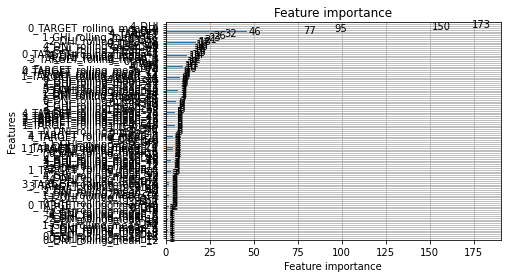

In [29]:
lgb.plot_importance(history[0][0.1]["bst_1"][0], figsize=(10, 20))

In [22]:
submission_df = load_submission_data()

result_list = history["submission_df"]
for result_df in result_list:
    for i in range(1, 10):
        q = i/10
        submission_df[f"q_{q}"] += result_df[f"q_{q}"]
                      
for i in range(1, 10):
    q = i/10
    submission_df[f"q_{q}"] = submission_df[f"q_{q}"] / index

In [23]:
submission_df[:48]

,id,q_0.1,q_0.2,q_0.3,q_0.4,q_0.5,q_0.6,q_0.7,q_0.8,q_0.9
0,0.csv_Day7_0h00m,0.000000,0.000000,0.000000,0.000000,0.000000,0.008983,0.009438,0.002316,0.000007
1,0.csv_Day7_0h30m,0.000000,0.000000,0.000000,0.000000,0.000000,0.008983,0.009438,0.002316,0.000007
2,0.csv_Day7_1h00m,0.000000,0.000000,0.000000,0.000000,0.000000,0.008983,0.009438,0.002316,0.000007
3,0.csv_Day7_1h30m,0.000000,0.000000,0.000000,0.000000,0.000000,0.008983,0.009438,0.002316,0.000007
4,0.csv_Day7_2h00m,0.000000,0.000000,0.000000,0.000000,0.000000,0.008983,0.009438,0.002316,0.000007
5,0.csv_Day7_2h30m,0.000000,0.000000,0.000000,0.000000,0.000000,0.008983,0.009438,0.002316,0.000007
6,0.csv_Day7_3h00m,0.000000,0.000000,0.000000,0.000000,0.000000,0.008983,0.009438,0.002316,0.000007
7,0.csv_Day7_3h30m,0.000000,0.000000,0.000000,0.000000,0.000000,0.008983,0.009438,0.002316,0.000007
8,0.csv_Day7_4h00m,0.000000,0.000000,0.000000,0.000000,0.000000,0.008983,0.009438,0.002316,0.000007
9,0.csv_Day7_4h30m,0.000000,0.000000,0.000000,0.000000,0.000000,0.008983,0.009438,0.002316,0.000007


In [ ]:
submission_df.to_csv("lightgbm_gbdt_split_dataset_2021_01_14_1.csv", index=False)